In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation,
                          Average, BatchNormalization, Flatten, Dense, Concatenate, LeakyReLU, Add)
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [3]:
##################################################################################################
##################################################################################################
#데이터 로드 + augmentation
train = pd.read_csv('data/train.csv')
train_img = train.iloc[:,3:].values.reshape(-1,28,28)
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')
y = train['digit']

def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    for x, y in zip(images, labels):        
        aug_images.append(x)
        aug_labels.append(y)
        
        bg_value = np.median(x)
        
        for _ in range(6):
            angle = np.random.randint(-10, 10, 1)            
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value)
            
            shift = np.random.randint(-3, 3, 2)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)            
            
            aug_images.append(shift_img)
            aug_labels.append(y)
            
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    
    return aug_images, aug_labels

train_X, valid_X, train_y, valid_y = train_test_split(train_img, y, test_size = 0.2)
train_X, train_y = data_augmentation(train_X, train_y)

train_X = train_X/255.
valid_X = valid_X/255.
train_X = np.expand_dims(train_X, axis=-1)
valid_X = np.expand_dims(valid_X, axis=-1)

train_y = to_categorical(train_y, 10)
valid_y = to_categorical(valid_y, 10)

#input
input_shape = train_X.shape[1:]
model_input = Input(shape=input_shape)
##################################################################################################
##################################################################################################

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

train = pd.read_csv('/content/drive/My Drive/cvision_1/train.csv')
test = pd.read_csv('/content/drive/My Drive/cvision_1/test.csv')
submission = pd.read_csv('/content/drive/My Drive/cvision_1/submission.csv')
train

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/cvision_1/train.csv'

In [47]:
#local 연결 전용

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

train = pd.read_csv('data/cvision/train.csv')
test = pd.read_csv('data/cvision/test.csv')
submission = pd.read_csv('data/cvision/submission.csv')
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [48]:
#X와 y 분리
X = train.drop(['id','digit','letter'], axis=1).values
X = X.reshape(-1, 28, 28, 1)
X = X/255.

y = train['digit']
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [49]:
#train과 valid로 분리
from sklearn.model_selection import train_test_split

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.1, random_state=42)

#test
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

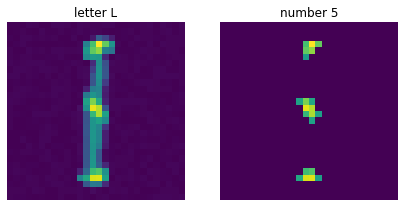

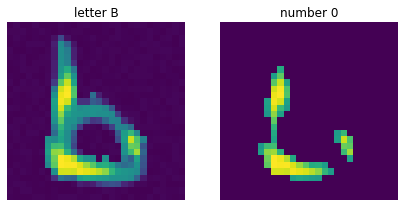

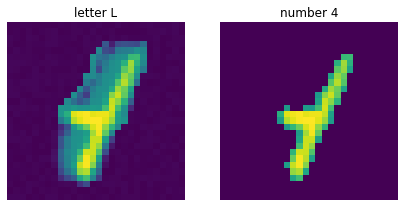

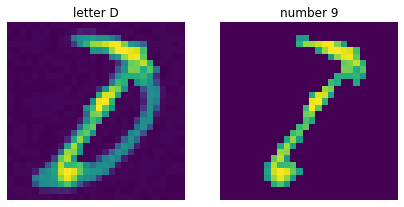

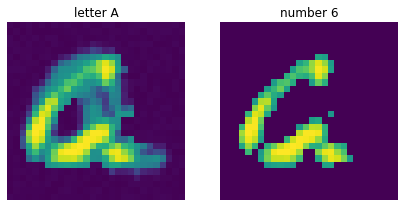

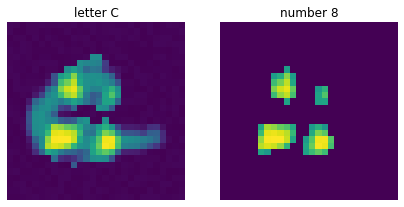

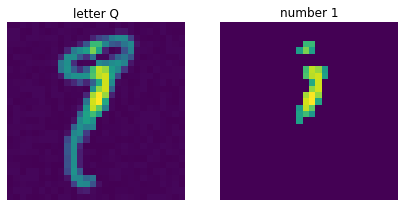

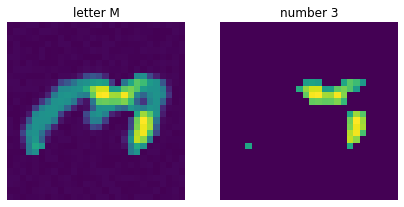

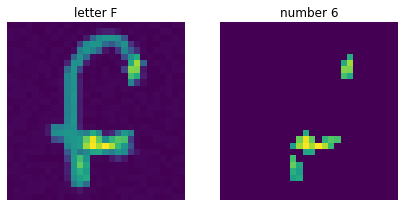

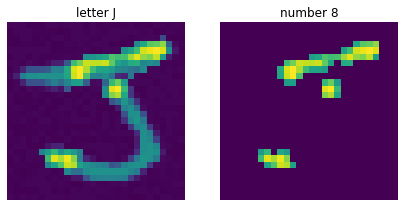

In [130]:
#그림 시각화
for i in range(10):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,2,1)
    img = train.iloc[i,3:].values.astype('int64').reshape(28,28)
    plt.imshow(img)
    plt.axis('off')
    plt.title('letter ' + str(train.iloc[i, 2]))
    
    plt.subplot(1,2,2)
    plt.imshow(np.where(img >= 135, img, 0))
    plt.axis('off')
    plt.title('number ' + str(train.iloc[i, 1]))

In [52]:
#숫자 있는 부분만 추출 (이걸로만 딥러닝해보니 성과 매우 안 좋음,
#이 방식 적용할 거면 train, valid, test 모두 이런 형식으로 변형한 후 해야할 듯)

train_X_ = np.where(train_X >= 135/255., train_X, 0)
valid_X_ = np.where(valid_X >= 135/255., valid_X, 0)
test_X_ = np.where(test_X >= 135/255., test_X, 0)

In [53]:
train_X_2 = np.concatenate([train_X, train_X_])
valid_X_2 = np.concatenate([valid_X, valid_X_])

train_y_2 = np.concatenate([train_y, train_y])
valid_y_2 = np.concatenate([valid_y, valid_y])

In [ ]:
#별 거 아님 kernel 예시
from scipy.signal import correlate2d

kernel = np.array(
[
    [0, -100, 0],
    [0, 255, 0],
    [0,-100,0]
])
plt.imshow(correlate2d(train_X[0].reshape(28,28), kernel, mode='same'))

In [201]:
#model_4
from tensorflow import keras
from tensorflow.keras import layers

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                            zoom_range=0.10,
                            width_shift_range=0.1,
                            height_shift_range=0.1)

def model_fn():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=3, activation='relu', input_shape = train_X.shape[1:]))
    model.add(Conv2D(32,kernel_size=3, activation='relu'))
    model.add(Conv2D(32,kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    model.add(Conv2D(64,kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128,kernel_size=4, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#model_5
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, #10도 돌림
                            zoom_range=0.10, #10퍼센트 확대(crop?)
                            width_shift_range=0.1,
                            height_shift_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = train_X.shape[1:], filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())

    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [203]:
model = model_fn()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 12, 12, 32)        9248      
_________________________________________________________________
dropout_40 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 4, 4, 64)        

In [204]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.975 ** x)

In [205]:
epochs = 120
batch_size = 32

history = model.fit_generator(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1
    #callbacks=[annealer],
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/120
57/57 [==============================] - 5s 89ms/step - loss: 2.2951 - accuracy: 0.1314 - val_loss: 2.2283 - val_accuracy: 0.1854
Epoch 2/120
57/57 [==============================] - 5s 87ms/step - loss: 2.1455 - accuracy: 0.2115 - val_loss: 1.7611 - val_accuracy: 0.4878
Epoch 3/120
57/57 [==============================] - 5s 87ms/step - loss: 1.9327 - accuracy: 0.3274 - val_loss: 1.4464 - val_accuracy: 0.5073
Epoch 4/120
57/57 [==============================] - 5s 87ms/step - loss: 1.7993 - accuracy: 0.3876 - val_loss: 1.4248 - val_accuracy: 0.5268
Epoch 5/120
57/57 [==============================] - 5s 87ms/step - loss: 1.7123 - accuracy: 0.3959 - val_loss: 1.2285 - val_accuracy: 0.6098
Epoch 6/120
57/57 [==============================] - 5s 87ms/step - loss: 1.5285 - accuracy: 0.4721 - val_loss: 1.0865 - val_accuracy: 0.6585
Epoch 7/120
57/57 [==============================] - 5s 88ms/step - loss: 1.4226 - accuracy: 0.5091 - val_loss: 1.1102 - val_accuracy: 0.6244
Epoch 

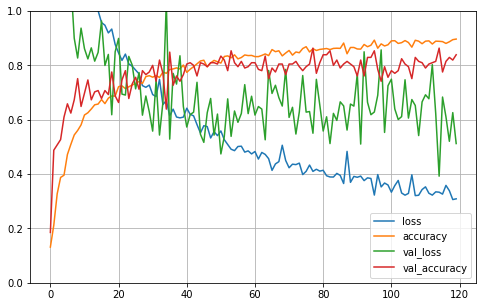

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#Parameter 저장
model.save_weights(f'/content/drive/My Drive/cvision_1/params_4.h5')

#모델 구조 저장
model_json = model.to_json()
with open(f'/content/drive/My Drive/cvision_1/model_4.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
#예측 진행
res = model.predict(test_X)

#submission 파일 생성
for i in range(len(res)):
    submission.digit[i] = int(res[i].argmax())
submission.to_csv('/content/drive/My Drive/cvision_1/my_subm_4.csv', index=False)

In [ ]:
#model_6
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, #10도 돌림
                            zoom_range=0.10, #10퍼센트 확대(crop?)
                            width_shift_range=0.1,
                            height_shift_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = train_X.shape[1:], filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())

    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#model_6
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10, #10도 돌림
                            zoom_range=0.1, #10퍼센트 확대(crop?)
                            width_shift_range=0.1,
                            height_shift_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = train_X.shape[1:], filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())

    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [192]:
model = model_fn()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
dropout_31 (Dropout)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

In [ ]:
epochs = 150
batch_size = 32

history = model.fit_generator(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1
    #callbacks=[annealer]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#Parameter 저장
model.save_weights(f'/content/drive/My Drive/cvision_1/params_6.h5')

#모델 구조 저장
model_json = model.to_json()
with open(f'/content/drive/My Drive/cvision_1/model_6.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('/content/drive/My Drive/cvision_1/my_subm_6.csv', index=False)

In [ ]:
#model_8인데 데이터 부풀리기 x, 학습률 감소 x
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''
datagen = ImageDataGenerator(rotation_range=10, #10도 돌림
                            zoom_range=0.1, #10퍼센트 확대(crop?)
                            width_shift_range=0.1,
                            height_shift_range=0.1)
'''
def model_fn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = train_X.shape[1:], filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())

    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#model_8인데 데이터 부풀리기 x, 학습률 감소 x
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''
datagen = ImageDataGenerator(rotation_range=10, #10도 돌림
                            zoom_range=0.1, #10퍼센트 확대(crop?)
                            width_shift_range=0.1,
                            height_shift_range=0.1)
'''
def model_fn():
    model = Sequential()
    
    model.add(Conv2D(input_shape = train_X.shape[1:], filters = 32, kernel_size = (3,3), strides = 2, padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())

    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = model_fn()
model.summary()

In [ ]:
epochs = 150
batch_size = 32

history = model.fit_generator(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1
    #callbacks=[annealer]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#Parameter 저장
model.save_weights(f'/content/drive/My Drive/cvision_1/params_9.h5')

#모델 구조 저장
model_json = model.to_json()
with open(f'/content/drive/My Drive/cvision_1/model_9.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('/content/drive/My Drive/cvision_1/my_subm_9.csv', index=False)

In [33]:
#model_9-3 9-2에서 optimizer만 RMSprop로 바꿔봄 - Adam보다 높게 나오더라
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax'))

    #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), Adagrad(lr=0.01, epsilon=None, decay=0.0), adadelta, adam
    model.compile(optimizer=RMSprop(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
model = model_fn()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 32)       

In [35]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=75)


In [36]:
epochs = 2000
batch_size = 128

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/2000
14/14 [==============================] - 1s 43ms/step - loss: 2.3137 - accuracy: 0.1050 - val_loss: 2.2994 - val_accuracy: 0.1024
Epoch 2/2000
14/14 [==============================] - 0s 28ms/step - loss: 2.2979 - accuracy: 0.1190 - val_loss: 2.2992 - val_accuracy: 0.0829
Epoch 3/2000
14/14 [==============================] - 0s 28ms/step - loss: 2.2917 - accuracy: 0.1149 - val_loss: 2.2879 - val_accuracy: 0.1073
Epoch 4/2000
14/14 [==============================] - 0s 28ms/step - loss: 2.2634 - accuracy: 0.1411 - val_loss: 2.2053 - val_accuracy: 0.1317
Epoch 5/2000
14/14 [==============================] - 0s 27ms/step - loss: 2.2351 - accuracy: 0.1656 - val_loss: 2.2253 - val_accuracy: 0.2000
Epoch 6/2000
14/14 [==============================] - 0s 28ms/step - loss: 2.1605 - accuracy: 0.2169 - val_loss: 2.1426 - val_accuracy: 0.3366
Epoch 7/2000
14/14 [==============================] - 0s 28ms/step - loss: 2.1125 - accuracy: 0.2315 - val_loss: 1.9375 - val_accuracy: 0.3463

Epoch 58/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0952 - accuracy: 0.6245 - val_loss: 0.7775 - val_accuracy: 0.7756
Epoch 59/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0050 - accuracy: 0.6612 - val_loss: 0.8179 - val_accuracy: 0.7220
Epoch 60/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0570 - accuracy: 0.6397 - val_loss: 0.8520 - val_accuracy: 0.7171
Epoch 61/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0098 - accuracy: 0.6612 - val_loss: 0.8856 - val_accuracy: 0.7561
Epoch 62/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0176 - accuracy: 0.6490 - val_loss: 0.7301 - val_accuracy: 0.8049
Epoch 63/2000
14/14 [==============================] - 0s 27ms/step - loss: 0.9999 - accuracy: 0.6548 - val_loss: 0.8837 - val_accuracy: 0.7561
Epoch 64/2000
14/14 [==============================] - 0s 28ms/step - loss: 1.0305 - accuracy: 0.6519 - val_loss: 0.8437 - val_accuracy:

Epoch 115/2000
14/14 [==============================] - 0s 27ms/step - loss: 0.6840 - accuracy: 0.7621 - val_loss: 0.6113 - val_accuracy: 0.8195
Epoch 116/2000
14/14 [==============================] - 0s 29ms/step - loss: 0.6871 - accuracy: 0.7718 - val_loss: 0.6718 - val_accuracy: 0.7610
Epoch 117/2000
14/14 [==============================] - 0s 28ms/step - loss: 0.7128 - accuracy: 0.7475 - val_loss: 0.5297 - val_accuracy: 0.8341
Epoch 118/2000
14/14 [==============================] - 0s 28ms/step - loss: 0.6597 - accuracy: 0.7673 - val_loss: 0.5080 - val_accuracy: 0.8439
Epoch 119/2000
14/14 [==============================] - 0s 28ms/step - loss: 0.6871 - accuracy: 0.7685 - val_loss: 0.7296 - val_accuracy: 0.7756
Epoch 120/2000
14/14 [==============================] - 0s 30ms/step - loss: 0.6709 - accuracy: 0.7697 - val_loss: 0.5698 - val_accuracy: 0.8439
Epoch 121/2000
14/14 [==============================] - 0s 27ms/step - loss: 0.7042 - accuracy: 0.7522 - val_loss: 0.5200 - val_ac

14/14 [==============================] - 0s 27ms/step - loss: 0.4502 - accuracy: 0.8431 - val_loss: 0.4726 - val_accuracy: 0.8439
Epoch 228/2000
14/14 [==============================] - 0s 29ms/step - loss: 0.3993 - accuracy: 0.8577 - val_loss: 0.5526 - val_accuracy: 0.8293
Epoch 229/2000
14/14 [==============================] - 0s 30ms/step - loss: 0.4472 - accuracy: 0.8449 - val_loss: 0.4715 - val_accuracy: 0.8341
Epoch 230/2000
14/14 [==============================] - 0s 28ms/step - loss: 0.4177 - accuracy: 0.8612 - val_loss: 0.4843 - val_accuracy: 0.8537
Epoch 231/2000
14/14 [==============================] - 0s 29ms/step - loss: 0.4523 - accuracy: 0.8484 - val_loss: 0.6254 - val_accuracy: 0.7854
Epoch 232/2000
14/14 [==============================] - 0s 27ms/step - loss: 0.4148 - accuracy: 0.8548 - val_loss: 0.4734 - val_accuracy: 0.8683
Epoch 233/2000
14/14 [==============================] - 0s 28ms/step - loss: 0.3949 - accuracy: 0.8606 - val_loss: 0.4445 - val_accuracy: 0.8537


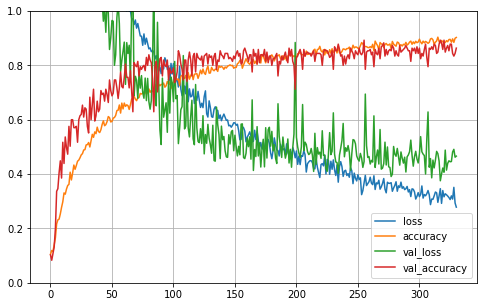

In [38]:
#맥스풀링 마지막에만 하고 FC두번 거쳐서 하니 느리지만 꾸준히 정확도 증가 80에서 거의 멈춤 - 해결 방안?
#epoch 180정도로 한 결과 = model_9
#model_9는 0.89166, 0.87805
#model_9-2를 eopch 230, relu 대신 leaky relu

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [39]:
#Parameter 저장
model.save_weights(f'data/cvision/params_9-5.h5')

#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/model_9-5.json', 'w') as json_file:
    json_file.write(model_json)


In [40]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_9-5.csv', index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [112]:
#model_9-6: 
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), Adam(0.001)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model_fn()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_279 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_222 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_280 (Conv2D)          (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_223 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 28, 28, 16)      

In [113]:
epochs = 100
batch_size = 16

#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
lrs = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

model_num = 'model_9-6'
MODEL_SAVE_FOLDER_PATH = './data/cvision/' + model_num + '/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-va{val_accuracy:.4f}-ep{epoch:02d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=0, save_best_only=True)

history = model.fit(
    x=train_X, y=train_y,
    epochs = epochs,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es, cp, lrs]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/100
359/359 [==============================] - 7s 18ms/step - loss: 1.8772 - accuracy: 0.3564 - val_loss: 4.1103 - val_accuracy: 0.1122
Epoch 2/100
359/359 [==============================] - 6s 17ms/step - loss: 1.2489 - accuracy: 0.5842 - val_loss: 1.5237 - val_accuracy: 0.5293
Epoch 3/100
359/359 [==============================] - 6s 18ms/step - loss: 0.9815 - accuracy: 0.6760 - val_loss: 0.8388 - val_accuracy: 0.7463
Epoch 4/100
359/359 [==============================] - 6s 17ms/step - loss: 0.8160 - accuracy: 0.7318 - val_loss: 0.7002 - val_accuracy: 0.7561
Epoch 5/100
359/359 [==============================] - 6s 18ms/step - loss: 0.7293 - accuracy: 0.7585 - val_loss: 0.6685 - val_accuracy: 0.7951
Epoch 6/100
359/359 [==============================] - 6s 18ms/step - loss: 0.6461 - accuracy: 0.7841 - val_loss: 0.5892 - val_accuracy: 0.8024
Epoch 7/100
359/359 [==============================] - 6s 17ms/step - loss: 0.5905 - accuracy: 0.8012 - val_loss: 0.4901 - val_accuracy:

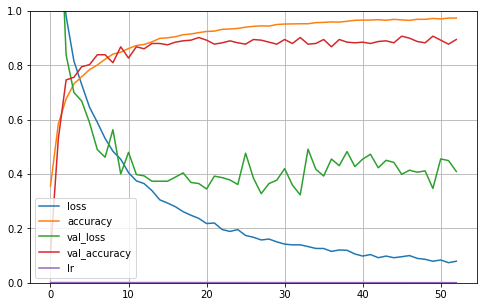

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [115]:
#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/' + model_num + 'auged' + '.json', 'w') as json_file:
    json_file.write(model_json)

#모델 불러와서 정확도 확인 및 예측
file_path = './data/cvision/' + model_num
files = os.listdir('./data/cvision/' + model_num)
hdf5_file = files[0] #폴더 맨 앞의 val_loss 가장 작은 파일 불러옴
print(hdf5_file)

model.load_weights(file_path + '/' + hdf5_file)

score = model.evaluate(valid_X, valid_y)
print('loss=', score[0])        # val_loss
print('accuracy=', score[1])    # val_accuracy

model_9-6vl0.3235-va0.9024-ep33.hdf5
13/13 [==============================] - 0s 6ms/step - loss: 0.3235 - accuracy: 0.9024
loss= 0.3234768807888031
accuracy= 0.9024389982223511


In [116]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_9-6_auged.csv', index=False)

In [48]:
#model_9-7: 
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))

    #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), Adam(0.001)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model_fn()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_27 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
activation_28 (Activation)   (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 28, 28, 16)      

In [49]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
lrs = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

model_num = 'model_9-7'
MODEL_SAVE_FOLDER_PATH = './data/cvision/' + model_num + '/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-va{val_accuracy:.4f}-ep{epoch:02d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=0, save_best_only=True)

In [50]:
epochs = 100
batch_size = 32

history = model.fit(
    x=train_X, y=train_y,
    epochs = epochs,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es, cp, lrs]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)


Epoch 1/100
359/359 [==============================] - 4s 11ms/step - loss: 1.8879 - accuracy: 0.3443 - val_loss: 2.4309 - val_accuracy: 0.1976
Epoch 2/100
359/359 [==============================] - 3s 10ms/step - loss: 1.1899 - accuracy: 0.6035 - val_loss: 0.8678 - val_accuracy: 0.7122
Epoch 3/100
359/359 [==============================] - 3s 9ms/step - loss: 0.8625 - accuracy: 0.7156 - val_loss: 0.5976 - val_accuracy: 0.8098
Epoch 4/100
359/359 [==============================] - 3s 9ms/step - loss: 0.6809 - accuracy: 0.7747 - val_loss: 0.5806 - val_accuracy: 0.8195
Epoch 5/100
359/359 [==============================] - 3s 9ms/step - loss: 0.5697 - accuracy: 0.8143 - val_loss: 0.5001 - val_accuracy: 0.8341
Epoch 6/100
359/359 [==============================] - 3s 9ms/step - loss: 0.4876 - accuracy: 0.8400 - val_loss: 0.5116 - val_accuracy: 0.8439
Epoch 7/100
359/359 [==============================] - 3s 9ms/step - loss: 0.4150 - accuracy: 0.8598 - val_loss: 0.4442 - val_accuracy: 0.85

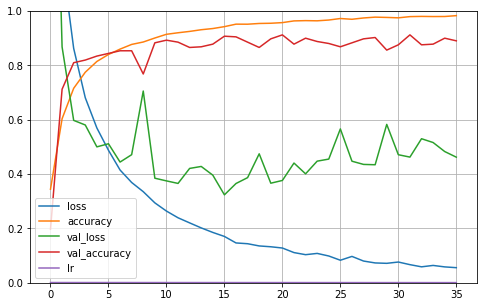

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [52]:
#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/' + model_num + 'auged' + '.json', 'w') as json_file:
    json_file.write(model_json)

#모델 불러와서 정확도 확인 및 예측
file_path = './data/cvision/' + model_num
files = os.listdir('./data/cvision/' + model_num)
hdf5_file = files[0] #폴더 맨 앞의 val_loss 가장 작은 파일 불러옴
print(hdf5_file)

model.load_weights(file_path + '/' + hdf5_file)

score = model.evaluate(valid_X, valid_y)
print('loss=', score[0])        # val_loss
print('accuracy=', score[1])    # val_accuracy

model_9-7vl0.3236-va0.9073-ep16.hdf5
13/13 [==============================] - 0s 4ms/step - loss: 0.3236 - accuracy: 0.9073
loss= 0.3236319124698639
accuracy= 0.9073171019554138


In [53]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_9-7_auged.csv', index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [106]:
#model_9-8: 
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(48, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(48, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Conv2D(64, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.001))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), Adam(0.001)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model_fn()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_271 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_213 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_272 (Conv2D)          (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_214 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_126 (Dropout)        (None, 28, 28, 16)      

In [107]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
lrs = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

model_num = 'model_9-8'
MODEL_SAVE_FOLDER_PATH = './data/cvision/' + model_num + '/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-va{val_accuracy:.4f}-ep{epoch:02d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=0, save_best_only=True)

In [108]:
epochs = 100
batch_size = 32

history = model.fit(
    x=train_X, y=train_y,
    epochs = epochs,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es, cp, lrs]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)


Epoch 1/100
359/359 [==============================] - 6s 16ms/step - loss: 1.9664 - accuracy: 0.3157 - val_loss: 3.1764 - val_accuracy: 0.1171
Epoch 2/100
359/359 [==============================] - 5s 14ms/step - loss: 1.4070 - accuracy: 0.5241 - val_loss: 1.3264 - val_accuracy: 0.5683
Epoch 3/100
359/359 [==============================] - 5s 14ms/step - loss: 1.1061 - accuracy: 0.6313 - val_loss: 0.9735 - val_accuracy: 0.6829
Epoch 4/100
359/359 [==============================] - 5s 14ms/step - loss: 0.9412 - accuracy: 0.6902 - val_loss: 0.7436 - val_accuracy: 0.7488
Epoch 5/100
359/359 [==============================] - 5s 14ms/step - loss: 0.8196 - accuracy: 0.7231 - val_loss: 0.7072 - val_accuracy: 0.7561
Epoch 6/100
359/359 [==============================] - 5s 14ms/step - loss: 0.7310 - accuracy: 0.7595 - val_loss: 0.5563 - val_accuracy: 0.8146
Epoch 7/100
359/359 [==============================] - 5s 14ms/step - loss: 0.6858 - accuracy: 0.7711 - val_loss: 0.6297 - val_accuracy:

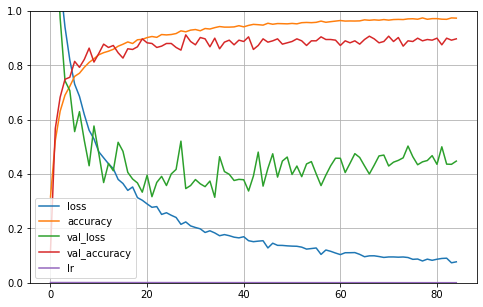

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [110]:
#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/' + model_num + 'auged' + '.json', 'w') as json_file:
    json_file.write(model_json)

#모델 불러와서 정확도 확인 및 예측
file_path = './data/cvision/' + model_num
files = os.listdir('./data/cvision/' + model_num)
hdf5_file = files[0] #폴더 맨 앞의 val_loss 가장 작은 파일 불러옴
print(hdf5_file)

model.load_weights(file_path + '/' + hdf5_file)

score = model.evaluate(valid_X, valid_y)
print('loss=', score[0])        # val_loss
print('accuracy=', score[1])    # val_accuracy

model_9-8vl0.3146-va0.9000-ep35.hdf5
13/13 [==============================] - 0s 5ms/step - loss: 0.3146 - accuracy: 0.9000
loss= 0.3146134912967682
accuracy= 0.8999999761581421


In [111]:
#예측 진행
res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_9-8_auged.csv', index=False)

In [ ]:
#model_9-9:
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(24, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(Conv2D(24, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(24, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))

    model.add(Conv2D(48, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(48, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(Conv2D(48, (3,3), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(50, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model_fn()
model.summary()

In [ ]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
lrs = LearningRateScheduler(lambda x: 1e-3 * 0.9995 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

model_num = 'model_9-9'
MODEL_SAVE_FOLDER_PATH = './data/cvision/' + model_num + '/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-va{val_accuracy:.4f}-ep{epoch:03d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=1, save_best_only=True)

In [ ]:
epochs = 3000
batch_size = 128

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es, cp]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [257]:
#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/' + model_num + '.json', 'w') as json_file:
    json_file.write(model_json)

#모델 불러와서 정확도 확인 및 예측
file_path = './data/cvision/' + model_num
files = os.listdir('./data/cvision/' + model_num)
hdf5_file = files[0]
print(hdf5_file)

model.load_weights(file_path + '/' + hdf5_file)

score = model.evaluate(valid_X, valid_y)
print('loss=', score[0])        # val_loss
print('accuracy=', score[1])    # val_accuracy

7/7 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8878
loss= 0.3157714605331421
accuracy= 0.8878048658370972


In [40]:
#예측 진행
test_X = test.drop(['id', 'letter'], axis=1).values
test_X = test_X.reshape(-1, 28, 28, 1)
test_X = test_X/255.

res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_9-9.csv', index=False)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [92]:
#model_10: ResNet 응용
from tensorflow import keras

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop, Adagrad

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
)

def conv1(x, filter_in=16):
    x = Conv2D(filter_in, (7,7), strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def conv2(x, layers=3, filter_in=16, filter_out=32):
    x = MaxPooling2D((3,3), 2)(x)
    
    shortcut = x
    
    for i in range(layers):
        if (i == 0):
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
        
    return x

def conv3(x, layers=4, filter_in=32, filter_out=64):
    shortcut = x
    
    for i in range(layers):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

def conv4(x, layers=6, filter_in=64, filter_out=128):
    shortcut = x
    
    for i in range(layers):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

def conv5(x, layers=3, filter_in=128, filter_out=256):
    shortcut = x
    
    for i in range(layers):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

#모델링
classes = 10
tensor_in = Input(shape= train_X.shape[1:], dtype='float32', name='input')
x = conv1(tensor_in)

x = Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
x = Conv2D(16, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
x = Dropout(0.4)(x)

x = Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
x = Conv2D(32, (3,3), padding = 'same', activation = 'relu', kernel_initializer='he_normal')(x)
x = Dropout(0.4)(x)

x = conv3(x, 1, 32, 64)
x = Dropout(0.4)(x)

x = conv4(x, 1, 64, 128)
x = Dropout(0.4)(x)

x = Flatten()(x)
tensor_out = Dense(classes, activation='softmax')(x)

model = Model(tensor_in, tensor_out)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 14, 14, 16)   800         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_186 (BatchN (None, 14, 14, 16)   64          conv2d_242[0][0]                 
__________________________________________________________________________________________________
activation_162 (Activation)     (None, 14, 14, 16)   0           batch_normalization_186[0][0]    
______________________________________________________________________________________

In [94]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** x)

#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=150)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

model_num = 'model_10'
MODEL_SAVE_FOLDER_PATH = './data/cvision/' + model_num + '/'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-va{val_accuracy:.4f}-ep{epoch:03d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=0, save_best_only=True)

In [95]:
epochs = 1000
batch_size = 32

history = model.fit(
    x=train_X, y=train_y,
    epochs = epochs,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[es, cp, lrs]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/1000
359/359 [==============================] - 3s 8ms/step - loss: 2.6721 - accuracy: 0.1675 - val_loss: 2.0380 - val_accuracy: 0.2561
Epoch 2/1000
359/359 [==============================] - 2s 7ms/step - loss: 2.1067 - accuracy: 0.2459 - val_loss: 1.8994 - val_accuracy: 0.3122
Epoch 3/1000
359/359 [==============================] - 2s 7ms/step - loss: 1.8694 - accuracy: 0.3274 - val_loss: 1.8822 - val_accuracy: 0.2951
Epoch 4/1000
359/359 [==============================] - 2s 6ms/step - loss: 1.6865 - accuracy: 0.3964 - val_loss: 2.0924 - val_accuracy: 0.2780
Epoch 5/1000
359/359 [==============================] - 2s 7ms/step - loss: 1.5576 - accuracy: 0.4542 - val_loss: 1.5080 - val_accuracy: 0.4537
Epoch 6/1000
359/359 [==============================] - 2s 7ms/step - loss: 1.4275 - accuracy: 0.4969 - val_loss: 1.3396 - val_accuracy: 0.5171
Epoch 7/1000
359/359 [==============================] - 2s 7ms/step - loss: 1.3050 - accuracy: 0.5334 - val_loss: 1.2092 - val_accuracy:

KeyboardInterrupt: 

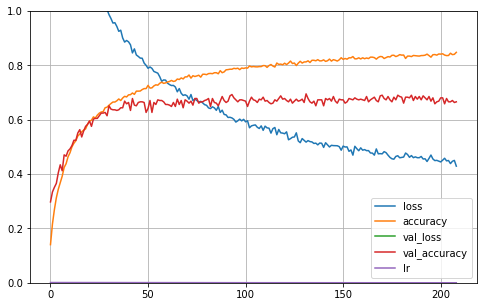

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [91]:
#모델 구조 저장
model_json = model.to_json()
with open(f'data/cvision/' + model_num + '_resnet_auged' + '.json', 'w') as json_file:
    json_file.write(model_json)

#모델 불러와서 정확도 확인 및 예측
file_path = './data/cvision/' + model_num
files = os.listdir('./data/cvision/' + model_num)
hdf5_file = files[0] #폴더 맨 앞의 val_loss 가장 작은 파일 불러옴
print(hdf5_file)

model.load_weights(file_path + '/' + hdf5_file)

score = model.evaluate(valid_X, valid_y)
print('loss=', score[0])        # val_loss
print('accuracy=', score[1])    # val_accuracy

#예측 진행
res = model.predict_classes(test_X)

submission.digit = res
submission.to_csv('data/cvision/my_subm_10_resnet_auged.csv', index=False)

model_10vl1.0138-va0.6659-ep059.hdf5
13/13 [==============================] - 0s 3ms/step - loss: 1.0138 - accuracy: 0.6659
loss= 1.013812780380249
accuracy= 0.6658536791801453


AttributeError: 'Functional' object has no attribute 'predict_classes'

In [ ]:
#model_10: ResNet - residual block 구성
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
)

def conv1(x):
    x = Conv2D(64, (7,7), strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def conv2(x, filter_in=64, filter_out=256):
    x = MaxPooling2D((3,3), 2)(x)
    
    shortcut = x
    
    for i in range(1):#3):
        if (i == 0):
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
        
    return x

def conv3(x, filter_in=128, filter_out=512):
    shortcut = x
    
    for i in range(2):#4):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

def conv4(x, filter_in=256, filter_out=1024):
    shortcut = x
    
    for i in range(1):#6):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

def conv5(x, filter_in=512, filter_out=2048):
    shortcut = x
    
    for i in range(1):#3):
        if(i == 0):
            x = Conv2D(filter_in, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            shortcut = Conv2D(filter_out, (1,1), strides=(2,2), padding='valid', kernel_initializer='he_normal')(shortcut) #각 layer의 첫 block에서는 dimension 증가 필요
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
            
        else:
            x = Conv2D(filter_in, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_in, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(filter_out, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
    
    return x

In [ ]:
#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

#모델링
classes = 10
tensor_in = Input(shape= train_X.shape[1:], dtype='float32', name='input')

x = conv1(tensor_in)
x = conv2(x)
x = conv3(x)
x = conv4(x)
x = conv5(x)

x = GlobalAveragePooling2D()(x)
tensor_out = Dense(classes, activation='softmax')(x)

model = Model(tensor_in, tensor_out)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1110 (Conv2D)            (None, 14, 14, 64)   3200        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1110 (Batch (None, 14, 14, 64)   256         conv2d_1110[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_545 (LeakyReLU)     (None, 14, 14, 64)   0           batch_normalization_1110[0][0]   
______________________________________________________________________________________

In [ ]:
#earlystopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=150)

#modelcheckpoint
from keras.callbacks import ModelCheckpoint
import os

MODEL_SAVE_FOLDER_PATH = './data/cvision/model_10/'
model_num = 'model_10'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + model_num +'vl{val_loss:.4f}-ep{epoch:02d}.hdf5'

cp = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                               verbose=1, save_best_only=True)

In [ ]:
epochs = 2000
batch_size = 128

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/4000
1/1 [==============================] - 1s 704ms/step - loss: 3.3559 - accuracy: 0.0964 - val_loss: 2.9831 - val_accuracy: 0.0877
Epoch 2/4000
1/1 [==============================] - 0s 67ms/step - loss: 3.3912 - accuracy: 0.1006 - val_loss: 2.8385 - val_accuracy: 0.0909
Epoch 3/4000
1/1 [==============================] - 0s 78ms/step - loss: 3.3649 - accuracy: 0.0992 - val_loss: 2.7397 - val_accuracy: 0.0974
Epoch 4/4000
1/1 [==============================] - 0s 78ms/step - loss: 3.1698 - accuracy: 0.1159 - val_loss: 2.6587 - val_accuracy: 0.0942
Epoch 5/4000
1/1 [==============================] - 0s 79ms/step - loss: 3.2307 - accuracy: 0.1103 - val_loss: 2.5902 - val_accuracy: 0.0974
Epoch 6/4000
1/1 [==============================] - 0s 83ms/step - loss: 3.1670 - accuracy: 0.1045 - val_loss: 2.5337 - val_accuracy: 0.0877
Epoch 7/4000
1/1 [==============================] - 0s 77ms/step - loss: 3.1895 - accuracy: 0.1034 - val_loss: 2.4875 - val_accuracy: 0.0877
Epoch 8/4000

Epoch 59/4000
1/1 [==============================] - 0s 79ms/step - loss: 2.5125 - accuracy: 0.1260 - val_loss: 2.2632 - val_accuracy: 0.1266
Epoch 60/4000
1/1 [==============================] - 0s 77ms/step - loss: 2.5432 - accuracy: 0.1089 - val_loss: 2.2628 - val_accuracy: 0.1396
Epoch 61/4000
1/1 [==============================] - 0s 81ms/step - loss: 2.5274 - accuracy: 0.1397 - val_loss: 2.2621 - val_accuracy: 0.1429
Epoch 62/4000
1/1 [==============================] - 0s 82ms/step - loss: 2.4883 - accuracy: 0.1221 - val_loss: 2.2610 - val_accuracy: 0.1429
Epoch 63/4000
1/1 [==============================] - 0s 82ms/step - loss: 2.5257 - accuracy: 0.1074 - val_loss: 2.2594 - val_accuracy: 0.1396
Epoch 64/4000
1/1 [==============================] - 0s 86ms/step - loss: 2.5400 - accuracy: 0.1172 - val_loss: 2.2577 - val_accuracy: 0.1494
Epoch 65/4000
1/1 [==============================] - 0s 75ms/step - loss: 2.4593 - accuracy: 0.1397 - val_loss: 2.2554 - val_accuracy: 0.1526
Epoch 

1/1 [==============================] - 0s 79ms/step - loss: 2.1894 - accuracy: 0.1983 - val_loss: 2.2052 - val_accuracy: 0.1721
Epoch 174/4000
1/1 [==============================] - 0s 84ms/step - loss: 2.1680 - accuracy: 0.1982 - val_loss: 2.2050 - val_accuracy: 0.1721
Epoch 175/4000
1/1 [==============================] - 0s 76ms/step - loss: 2.1786 - accuracy: 0.1802 - val_loss: 2.2041 - val_accuracy: 0.1721
Epoch 176/4000
1/1 [==============================] - 0s 85ms/step - loss: 2.2019 - accuracy: 0.1738 - val_loss: 2.2034 - val_accuracy: 0.1721
Epoch 177/4000
1/1 [==============================] - 0s 85ms/step - loss: 2.1919 - accuracy: 0.1992 - val_loss: 2.2026 - val_accuracy: 0.1721
Epoch 178/4000
1/1 [==============================] - 0s 78ms/step - loss: 2.2139 - accuracy: 0.2053 - val_loss: 2.2020 - val_accuracy: 0.1721
Epoch 179/4000
1/1 [==============================] - 0s 83ms/step - loss: 2.2114 - accuracy: 0.1865 - val_loss: 2.2013 - val_accuracy: 0.1656
Epoch 180/4000

1/1 [==============================] - 0s 83ms/step - loss: 2.0455 - accuracy: 0.2334 - val_loss: 1.9660 - val_accuracy: 0.3149
Epoch 288/4000
1/1 [==============================] - 0s 88ms/step - loss: 2.0462 - accuracy: 0.2461 - val_loss: 1.9639 - val_accuracy: 0.3149
Epoch 289/4000
1/1 [==============================] - 0s 80ms/step - loss: 2.0128 - accuracy: 0.2640 - val_loss: 1.9619 - val_accuracy: 0.3149
Epoch 290/4000
1/1 [==============================] - 0s 89ms/step - loss: 2.0888 - accuracy: 0.2275 - val_loss: 1.9600 - val_accuracy: 0.3149
Epoch 291/4000
1/1 [==============================] - 0s 82ms/step - loss: 2.0489 - accuracy: 0.2612 - val_loss: 1.9577 - val_accuracy: 0.3214
Epoch 292/4000
1/1 [==============================] - 0s 80ms/step - loss: 2.0396 - accuracy: 0.2263 - val_loss: 1.9554 - val_accuracy: 0.3279
Epoch 293/4000
1/1 [==============================] - 0s 86ms/step - loss: 2.0554 - accuracy: 0.2432 - val_loss: 1.9534 - val_accuracy: 0.3247
Epoch 294/4000

1/1 [==============================] - 0s 85ms/step - loss: 1.9063 - accuracy: 0.3076 - val_loss: 1.8186 - val_accuracy: 0.3377
Epoch 402/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.9480 - accuracy: 0.3008 - val_loss: 1.8158 - val_accuracy: 0.3344
Epoch 403/4000
1/1 [==============================] - 0s 86ms/step - loss: 1.9268 - accuracy: 0.2793 - val_loss: 1.8129 - val_accuracy: 0.3377
Epoch 404/4000
1/1 [==============================] - 0s 87ms/step - loss: 1.8918 - accuracy: 0.3252 - val_loss: 1.8107 - val_accuracy: 0.3344
Epoch 405/4000
1/1 [==============================] - 0s 79ms/step - loss: 1.9472 - accuracy: 0.2696 - val_loss: 1.8092 - val_accuracy: 0.3312
Epoch 406/4000
1/1 [==============================] - 0s 91ms/step - loss: 1.8684 - accuracy: 0.3213 - val_loss: 1.8075 - val_accuracy: 0.3344
Epoch 407/4000
1/1 [==============================] - 0s 80ms/step - loss: 1.9073 - accuracy: 0.2891 - val_loss: 1.8057 - val_accuracy: 0.3344
Epoch 408/4000

1/1 [==============================] - 0s 84ms/step - loss: 1.8231 - accuracy: 0.3633 - val_loss: 1.7782 - val_accuracy: 0.3799
Epoch 516/4000
1/1 [==============================] - 0s 86ms/step - loss: 1.7667 - accuracy: 0.3613 - val_loss: 1.7692 - val_accuracy: 0.3864
Epoch 517/4000
1/1 [==============================] - 0s 87ms/step - loss: 1.7579 - accuracy: 0.3662 - val_loss: 1.7585 - val_accuracy: 0.3929
Epoch 518/4000
1/1 [==============================] - 0s 81ms/step - loss: 1.7807 - accuracy: 0.3877 - val_loss: 1.7494 - val_accuracy: 0.3994
Epoch 519/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.8183 - accuracy: 0.3575 - val_loss: 1.7454 - val_accuracy: 0.3961
Epoch 520/4000
1/1 [==============================] - 0s 80ms/step - loss: 1.7888 - accuracy: 0.3506 - val_loss: 1.7421 - val_accuracy: 0.4026
Epoch 521/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.7857 - accuracy: 0.3545 - val_loss: 1.7419 - val_accuracy: 0.4058
Epoch 522/4000

1/1 [==============================] - 0s 86ms/step - loss: 1.6551 - accuracy: 0.4053 - val_loss: 1.6304 - val_accuracy: 0.4286
Epoch 630/4000
1/1 [==============================] - 0s 87ms/step - loss: 1.6635 - accuracy: 0.4062 - val_loss: 1.6291 - val_accuracy: 0.4318
Epoch 631/4000
1/1 [==============================] - 0s 74ms/step - loss: 1.6157 - accuracy: 0.4358 - val_loss: 1.6192 - val_accuracy: 0.4286
Epoch 632/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.6572 - accuracy: 0.4150 - val_loss: 1.6079 - val_accuracy: 0.4253
Epoch 633/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.6116 - accuracy: 0.3841 - val_loss: 1.6030 - val_accuracy: 0.4188
Epoch 634/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.6371 - accuracy: 0.4092 - val_loss: 1.6054 - val_accuracy: 0.4123
Epoch 635/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.6415 - accuracy: 0.4180 - val_loss: 1.6094 - val_accuracy: 0.4123
Epoch 636/4000

1/1 [==============================] - 0s 85ms/step - loss: 1.5436 - accuracy: 0.4424 - val_loss: 1.6720 - val_accuracy: 0.4416
Epoch 744/4000
1/1 [==============================] - 0s 86ms/step - loss: 1.4480 - accuracy: 0.4863 - val_loss: 1.6591 - val_accuracy: 0.4578
Epoch 745/4000
1/1 [==============================] - 0s 86ms/step - loss: 1.4985 - accuracy: 0.4658 - val_loss: 1.6400 - val_accuracy: 0.4740
Epoch 746/4000
1/1 [==============================] - 0s 76ms/step - loss: 1.4812 - accuracy: 0.4930 - val_loss: 1.6397 - val_accuracy: 0.4740
Epoch 747/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.4869 - accuracy: 0.4777 - val_loss: 1.6422 - val_accuracy: 0.4643
Epoch 748/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.5227 - accuracy: 0.4619 - val_loss: 1.6581 - val_accuracy: 0.4643
Epoch 749/4000
1/1 [==============================] - 0s 88ms/step - loss: 1.5058 - accuracy: 0.4883 - val_loss: 1.6809 - val_accuracy: 0.4481
Epoch 750/4000

1/1 [==============================] - 0s 76ms/step - loss: 1.3809 - accuracy: 0.5168 - val_loss: 1.6831 - val_accuracy: 0.4643
Epoch 858/4000
1/1 [==============================] - 0s 82ms/step - loss: 1.4559 - accuracy: 0.4717 - val_loss: 1.7616 - val_accuracy: 0.4610
Epoch 859/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.4036 - accuracy: 0.5042 - val_loss: 1.8207 - val_accuracy: 0.4351
Epoch 860/4000
1/1 [==============================] - 0s 88ms/step - loss: 1.4042 - accuracy: 0.5146 - val_loss: 1.8310 - val_accuracy: 0.4221
Epoch 861/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.3770 - accuracy: 0.5312 - val_loss: 1.8074 - val_accuracy: 0.4253
Epoch 862/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.4181 - accuracy: 0.5166 - val_loss: 1.7462 - val_accuracy: 0.4416
Epoch 863/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.3957 - accuracy: 0.5042 - val_loss: 1.6836 - val_accuracy: 0.4416
Epoch 864/4000

1/1 [==============================] - 0s 83ms/step - loss: 1.2989 - accuracy: 0.5469 - val_loss: 1.4211 - val_accuracy: 0.5162
Epoch 972/4000
1/1 [==============================] - 0s 75ms/step - loss: 1.3307 - accuracy: 0.5391 - val_loss: 1.3917 - val_accuracy: 0.5195
Epoch 973/4000
1/1 [==============================] - 0s 76ms/step - loss: 1.3652 - accuracy: 0.5279 - val_loss: 1.3415 - val_accuracy: 0.5519
Epoch 974/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.2571 - accuracy: 0.5628 - val_loss: 1.2995 - val_accuracy: 0.5942
Epoch 975/4000
1/1 [==============================] - 0s 79ms/step - loss: 1.2777 - accuracy: 0.5517 - val_loss: 1.2724 - val_accuracy: 0.5877
Epoch 976/4000
1/1 [==============================] - 0s 84ms/step - loss: 1.2493 - accuracy: 0.5449 - val_loss: 1.2528 - val_accuracy: 0.5942
Epoch 977/4000
1/1 [==============================] - 0s 79ms/step - loss: 1.2969 - accuracy: 0.5782 - val_loss: 1.2469 - val_accuracy: 0.5812
Epoch 978/4000

1/1 [==============================] - 0s 76ms/step - loss: 1.1556 - accuracy: 0.6089 - val_loss: 1.1186 - val_accuracy: 0.6136
Epoch 1086/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.1980 - accuracy: 0.5964 - val_loss: 1.1272 - val_accuracy: 0.6104
Epoch 1087/4000
1/1 [==============================] - 0s 85ms/step - loss: 1.1287 - accuracy: 0.6064 - val_loss: 1.1387 - val_accuracy: 0.6104
Epoch 1088/4000
1/1 [==============================] - 0s 90ms/step - loss: 1.2165 - accuracy: 0.5645 - val_loss: 1.1521 - val_accuracy: 0.5974
Epoch 1089/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.2081 - accuracy: 0.5936 - val_loss: 1.1560 - val_accuracy: 0.5942
Epoch 1090/4000
1/1 [==============================] - 0s 81ms/step - loss: 1.1520 - accuracy: 0.6074 - val_loss: 1.1616 - val_accuracy: 0.5909
Epoch 1091/4000
1/1 [==============================] - 0s 79ms/step - loss: 1.1097 - accuracy: 0.6411 - val_loss: 1.1606 - val_accuracy: 0.5942
Epoch 10

Epoch 1199/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.1041 - accuracy: 0.6191 - val_loss: 1.3476 - val_accuracy: 0.5714
Epoch 1200/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.0735 - accuracy: 0.6348 - val_loss: 1.3675 - val_accuracy: 0.5617
Epoch 1201/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.0849 - accuracy: 0.6338 - val_loss: 1.3686 - val_accuracy: 0.5584
Epoch 1202/4000
1/1 [==============================] - 0s 86ms/step - loss: 1.0975 - accuracy: 0.6445 - val_loss: 1.3793 - val_accuracy: 0.5552
Epoch 1203/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.0328 - accuracy: 0.6523 - val_loss: 1.3727 - val_accuracy: 0.5617
Epoch 1204/4000
1/1 [==============================] - 0s 77ms/step - loss: 1.0505 - accuracy: 0.6257 - val_loss: 1.3932 - val_accuracy: 0.5455
Epoch 1205/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.0169 - accuracy: 0.6522 - val_loss: 1.4052 - val_accuracy:

Epoch 1256/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.9710 - accuracy: 0.6660 - val_loss: 1.2305 - val_accuracy: 0.5682
Epoch 1257/4000
1/1 [==============================] - 0s 78ms/step - loss: 1.0238 - accuracy: 0.6606 - val_loss: 1.2512 - val_accuracy: 0.5812
Epoch 1258/4000
1/1 [==============================] - 0s 90ms/step - loss: 1.0424 - accuracy: 0.6494 - val_loss: 1.2700 - val_accuracy: 0.5779
Epoch 1259/4000
1/1 [==============================] - 0s 83ms/step - loss: 1.1036 - accuracy: 0.6055 - val_loss: 1.2601 - val_accuracy: 0.5779
Epoch 1260/4000
1/1 [==============================] - 0s 82ms/step - loss: 1.0136 - accuracy: 0.6634 - val_loss: 1.2257 - val_accuracy: 0.5942
Epoch 1261/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.9823 - accuracy: 0.6816 - val_loss: 1.1874 - val_accuracy: 0.5974
Epoch 1262/4000
1/1 [==============================] - 0s 76ms/step - loss: 1.0253 - accuracy: 0.6453 - val_loss: 1.1527 - val_accuracy:

Epoch 1313/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.9726 - accuracy: 0.6816 - val_loss: 1.0493 - val_accuracy: 0.6266
Epoch 1314/4000
1/1 [==============================] - 0s 91ms/step - loss: 1.0321 - accuracy: 0.6602 - val_loss: 1.0572 - val_accuracy: 0.6266
Epoch 1315/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.9759 - accuracy: 0.6699 - val_loss: 1.0698 - val_accuracy: 0.6364
Epoch 1316/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.9165 - accuracy: 0.6836 - val_loss: 1.0696 - val_accuracy: 0.6299
Epoch 1317/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.9605 - accuracy: 0.6924 - val_loss: 1.0667 - val_accuracy: 0.6364
Epoch 1318/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.9307 - accuracy: 0.6758 - val_loss: 1.0716 - val_accuracy: 0.6364
Epoch 1319/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.9961 - accuracy: 0.6718 - val_loss: 1.0687 - val_accuracy:

Epoch 1370/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.9536 - accuracy: 0.6836 - val_loss: 1.1855 - val_accuracy: 0.5909
Epoch 1371/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.8744 - accuracy: 0.6941 - val_loss: 1.1664 - val_accuracy: 0.5877
Epoch 1372/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.9765 - accuracy: 0.6680 - val_loss: 1.1423 - val_accuracy: 0.5909
Epoch 1373/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.9388 - accuracy: 0.6760 - val_loss: 1.1295 - val_accuracy: 0.6006
Epoch 1374/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.9582 - accuracy: 0.6774 - val_loss: 1.1451 - val_accuracy: 0.5974
Epoch 1375/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.9122 - accuracy: 0.6826 - val_loss: 1.1526 - val_accuracy: 0.5974
Epoch 1376/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.9427 - accuracy: 0.6816 - val_loss: 1.1432 - val_accuracy:

Epoch 1427/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.9357 - accuracy: 0.6858 - val_loss: 1.1937 - val_accuracy: 0.6104
Epoch 1428/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.8900 - accuracy: 0.7158 - val_loss: 1.2270 - val_accuracy: 0.5974
Epoch 1429/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.8966 - accuracy: 0.6973 - val_loss: 1.1997 - val_accuracy: 0.6006
Epoch 1430/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.8488 - accuracy: 0.7123 - val_loss: 1.1691 - val_accuracy: 0.6104
Epoch 1431/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.9171 - accuracy: 0.6914 - val_loss: 1.1402 - val_accuracy: 0.6104
Epoch 1432/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.8458 - accuracy: 0.7179 - val_loss: 1.1447 - val_accuracy: 0.6071
Epoch 1433/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.9064 - accuracy: 0.6997 - val_loss: 1.1808 - val_accuracy:

Epoch 1484/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.8196 - accuracy: 0.7360 - val_loss: 1.1331 - val_accuracy: 0.6266
Epoch 1485/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.9236 - accuracy: 0.6955 - val_loss: 1.1074 - val_accuracy: 0.6331
Epoch 1486/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.8865 - accuracy: 0.7179 - val_loss: 1.0869 - val_accuracy: 0.6266
Epoch 1487/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.8274 - accuracy: 0.7053 - val_loss: 1.0880 - val_accuracy: 0.6266
Epoch 1488/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.8508 - accuracy: 0.7165 - val_loss: 1.1132 - val_accuracy: 0.6299
Epoch 1489/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.8052 - accuracy: 0.7246 - val_loss: 1.1538 - val_accuracy: 0.6071
Epoch 1490/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.8263 - accuracy: 0.7139 - val_loss: 1.1953 - val_accuracy:

Epoch 1541/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.8375 - accuracy: 0.7363 - val_loss: 1.2163 - val_accuracy: 0.6071
Epoch 1542/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.8436 - accuracy: 0.7236 - val_loss: 1.1702 - val_accuracy: 0.6104
Epoch 1543/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.8198 - accuracy: 0.7363 - val_loss: 1.1168 - val_accuracy: 0.6169
Epoch 1544/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.9080 - accuracy: 0.6955 - val_loss: 1.0803 - val_accuracy: 0.6266
Epoch 1545/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.8448 - accuracy: 0.7193 - val_loss: 1.0735 - val_accuracy: 0.6331
Epoch 1546/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.8604 - accuracy: 0.7100 - val_loss: 1.0749 - val_accuracy: 0.6331
Epoch 1547/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.8325 - accuracy: 0.7291 - val_loss: 1.0665 - val_accuracy:

Epoch 1598/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.8128 - accuracy: 0.7318 - val_loss: 1.2305 - val_accuracy: 0.6136
Epoch 1599/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.8944 - accuracy: 0.7053 - val_loss: 1.2694 - val_accuracy: 0.6136
Epoch 1600/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.7884 - accuracy: 0.7363 - val_loss: 1.2825 - val_accuracy: 0.6104
Epoch 1601/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.8597 - accuracy: 0.7188 - val_loss: 1.2786 - val_accuracy: 0.6104
Epoch 1602/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.8242 - accuracy: 0.7383 - val_loss: 1.2005 - val_accuracy: 0.6299
Epoch 1603/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.8255 - accuracy: 0.7277 - val_loss: 1.1291 - val_accuracy: 0.6331
Epoch 1604/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.8160 - accuracy: 0.7305 - val_loss: 1.0798 - val_accuracy:

Epoch 1655/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.7771 - accuracy: 0.7360 - val_loss: 1.0336 - val_accuracy: 0.6688
Epoch 1656/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.7849 - accuracy: 0.7263 - val_loss: 1.0576 - val_accuracy: 0.6623
Epoch 1657/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.8007 - accuracy: 0.7393 - val_loss: 1.0834 - val_accuracy: 0.6623
Epoch 1658/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.7628 - accuracy: 0.7556 - val_loss: 1.1362 - val_accuracy: 0.6396
Epoch 1659/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.7369 - accuracy: 0.7668 - val_loss: 1.1976 - val_accuracy: 0.6169
Epoch 1660/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.7490 - accuracy: 0.7514 - val_loss: 1.2231 - val_accuracy: 0.6266
Epoch 1661/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.7472 - accuracy: 0.7637 - val_loss: 1.2286 - val_accuracy:

Epoch 1712/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.7811 - accuracy: 0.7388 - val_loss: 1.2149 - val_accuracy: 0.6331
Epoch 1713/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.7447 - accuracy: 0.7570 - val_loss: 1.1996 - val_accuracy: 0.6266
Epoch 1714/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.7268 - accuracy: 0.7514 - val_loss: 1.1916 - val_accuracy: 0.6331
Epoch 1715/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.7172 - accuracy: 0.7656 - val_loss: 1.1834 - val_accuracy: 0.6396
Epoch 1716/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.6961 - accuracy: 0.7744 - val_loss: 1.1802 - val_accuracy: 0.6331
Epoch 1717/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.7435 - accuracy: 0.7360 - val_loss: 1.1799 - val_accuracy: 0.6396
Epoch 1718/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.7589 - accuracy: 0.7607 - val_loss: 1.1801 - val_accuracy:

Epoch 1769/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.7233 - accuracy: 0.7646 - val_loss: 1.2095 - val_accuracy: 0.6234
Epoch 1770/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.7225 - accuracy: 0.7715 - val_loss: 1.2088 - val_accuracy: 0.6039
Epoch 1771/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.7315 - accuracy: 0.7773 - val_loss: 1.2005 - val_accuracy: 0.6136
Epoch 1772/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.7859 - accuracy: 0.7432 - val_loss: 1.1952 - val_accuracy: 0.6299
Epoch 1773/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.6498 - accuracy: 0.7723 - val_loss: 1.1933 - val_accuracy: 0.6331
Epoch 1774/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.7555 - accuracy: 0.7556 - val_loss: 1.1831 - val_accuracy: 0.6299
Epoch 1775/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.6843 - accuracy: 0.7822 - val_loss: 1.1751 - val_accuracy:

Epoch 1826/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.6967 - accuracy: 0.7764 - val_loss: 1.1023 - val_accuracy: 0.6494
Epoch 1827/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.6811 - accuracy: 0.7654 - val_loss: 1.1036 - val_accuracy: 0.6558
Epoch 1828/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.7056 - accuracy: 0.7654 - val_loss: 1.1111 - val_accuracy: 0.6364
Epoch 1829/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.7070 - accuracy: 0.7709 - val_loss: 1.1190 - val_accuracy: 0.6331
Epoch 1830/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6501 - accuracy: 0.7737 - val_loss: 1.1354 - val_accuracy: 0.6396
Epoch 1831/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.6641 - accuracy: 0.7900 - val_loss: 1.1386 - val_accuracy: 0.6461
Epoch 1832/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.7132 - accuracy: 0.7751 - val_loss: 1.1505 - val_accuracy:

Epoch 1883/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.7244 - accuracy: 0.7556 - val_loss: 1.1661 - val_accuracy: 0.6526
Epoch 1884/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.6688 - accuracy: 0.7779 - val_loss: 1.1541 - val_accuracy: 0.6623
Epoch 1885/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.6673 - accuracy: 0.7832 - val_loss: 1.1581 - val_accuracy: 0.6494
Epoch 1886/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.6670 - accuracy: 0.7910 - val_loss: 1.1488 - val_accuracy: 0.6494
Epoch 1887/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6779 - accuracy: 0.7989 - val_loss: 1.1458 - val_accuracy: 0.6494
Epoch 1888/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6950 - accuracy: 0.7737 - val_loss: 1.1254 - val_accuracy: 0.6526
Epoch 1889/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.6446 - accuracy: 0.7891 - val_loss: 1.1044 - val_accuracy:

Epoch 1940/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.7395 - accuracy: 0.7510 - val_loss: 1.1602 - val_accuracy: 0.6429
Epoch 1941/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.6232 - accuracy: 0.7998 - val_loss: 1.1572 - val_accuracy: 0.6494
Epoch 1942/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.6328 - accuracy: 0.7939 - val_loss: 1.1527 - val_accuracy: 0.6494
Epoch 1943/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.6757 - accuracy: 0.7646 - val_loss: 1.1453 - val_accuracy: 0.6461
Epoch 1944/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5724 - accuracy: 0.8086 - val_loss: 1.1403 - val_accuracy: 0.6526
Epoch 1945/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.6594 - accuracy: 0.7803 - val_loss: 1.1455 - val_accuracy: 0.6494
Epoch 1946/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6217 - accuracy: 0.7891 - val_loss: 1.1517 - val_accuracy:

Epoch 1997/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.6222 - accuracy: 0.7877 - val_loss: 1.1461 - val_accuracy: 0.6429
Epoch 1998/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.6324 - accuracy: 0.7933 - val_loss: 1.1219 - val_accuracy: 0.6331
Epoch 1999/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.6257 - accuracy: 0.7961 - val_loss: 1.1188 - val_accuracy: 0.6331
Epoch 2000/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.5651 - accuracy: 0.8115 - val_loss: 1.1225 - val_accuracy: 0.6299
Epoch 2001/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.6723 - accuracy: 0.7807 - val_loss: 1.1259 - val_accuracy: 0.6429
Epoch 2002/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.6680 - accuracy: 0.7779 - val_loss: 1.1271 - val_accuracy: 0.6461
Epoch 2003/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6443 - accuracy: 0.7793 - val_loss: 1.1401 - val_accuracy:

Epoch 2054/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.6987 - accuracy: 0.7514 - val_loss: 1.0716 - val_accuracy: 0.6461
Epoch 2055/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.6891 - accuracy: 0.7696 - val_loss: 1.0890 - val_accuracy: 0.6494
Epoch 2056/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.6145 - accuracy: 0.7905 - val_loss: 1.1069 - val_accuracy: 0.6558
Epoch 2057/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5975 - accuracy: 0.7849 - val_loss: 1.1056 - val_accuracy: 0.6526
Epoch 2058/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.6340 - accuracy: 0.7861 - val_loss: 1.0996 - val_accuracy: 0.6656
Epoch 2059/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.6576 - accuracy: 0.7751 - val_loss: 1.0952 - val_accuracy: 0.6623
Epoch 2060/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.5606 - accuracy: 0.8170 - val_loss: 1.0982 - val_accuracy:

Epoch 2111/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5939 - accuracy: 0.8156 - val_loss: 1.2939 - val_accuracy: 0.6169
Epoch 2112/4000
1/1 [==============================] - 0s 91ms/step - loss: 0.6493 - accuracy: 0.7920 - val_loss: 1.2474 - val_accuracy: 0.6234
Epoch 2113/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.5826 - accuracy: 0.8174 - val_loss: 1.2011 - val_accuracy: 0.6201
Epoch 2114/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6505 - accuracy: 0.7919 - val_loss: 1.1880 - val_accuracy: 0.6364
Epoch 2115/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.6219 - accuracy: 0.7863 - val_loss: 1.1773 - val_accuracy: 0.6299
Epoch 2116/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.6493 - accuracy: 0.7988 - val_loss: 1.1483 - val_accuracy: 0.6364
Epoch 2117/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.5950 - accuracy: 0.8027 - val_loss: 1.1140 - val_accuracy:

Epoch 2168/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5220 - accuracy: 0.8352 - val_loss: 1.3075 - val_accuracy: 0.6136
Epoch 2169/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.6076 - accuracy: 0.7975 - val_loss: 1.2299 - val_accuracy: 0.6201
Epoch 2170/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.5848 - accuracy: 0.8087 - val_loss: 1.1578 - val_accuracy: 0.6201
Epoch 2171/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.6275 - accuracy: 0.8031 - val_loss: 1.1170 - val_accuracy: 0.6266
Epoch 2172/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.6047 - accuracy: 0.7989 - val_loss: 1.1024 - val_accuracy: 0.6429
Epoch 2173/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.5401 - accuracy: 0.8198 - val_loss: 1.1114 - val_accuracy: 0.6429
Epoch 2174/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.5502 - accuracy: 0.8174 - val_loss: 1.1282 - val_accuracy:

Epoch 2225/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.5101 - accuracy: 0.8142 - val_loss: 1.2499 - val_accuracy: 0.6136
Epoch 2226/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4849 - accuracy: 0.8478 - val_loss: 1.2883 - val_accuracy: 0.6104
Epoch 2227/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.5387 - accuracy: 0.8232 - val_loss: 1.3385 - val_accuracy: 0.5974
Epoch 2228/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5934 - accuracy: 0.8125 - val_loss: 1.3534 - val_accuracy: 0.5877
Epoch 2229/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.5838 - accuracy: 0.7989 - val_loss: 1.3188 - val_accuracy: 0.6071
Epoch 2230/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.5160 - accuracy: 0.8311 - val_loss: 1.2892 - val_accuracy: 0.6039
Epoch 2231/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.5489 - accuracy: 0.8223 - val_loss: 1.2573 - val_accuracy:

Epoch 2282/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5545 - accuracy: 0.8213 - val_loss: 1.5443 - val_accuracy: 0.5584
Epoch 2283/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.5384 - accuracy: 0.8213 - val_loss: 1.4767 - val_accuracy: 0.5682
Epoch 2284/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5254 - accuracy: 0.8198 - val_loss: 1.4425 - val_accuracy: 0.5682
Epoch 2285/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5209 - accuracy: 0.8320 - val_loss: 1.3988 - val_accuracy: 0.5714
Epoch 2286/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.5201 - accuracy: 0.8338 - val_loss: 1.3720 - val_accuracy: 0.5649
Epoch 2287/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5206 - accuracy: 0.8262 - val_loss: 1.3398 - val_accuracy: 0.5779
Epoch 2288/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.5367 - accuracy: 0.8240 - val_loss: 1.3128 - val_accuracy:

Epoch 2339/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.5649 - accuracy: 0.8125 - val_loss: 1.1847 - val_accuracy: 0.6364
Epoch 2340/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.4812 - accuracy: 0.8324 - val_loss: 1.1695 - val_accuracy: 0.6494
Epoch 2341/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.4824 - accuracy: 0.8352 - val_loss: 1.1769 - val_accuracy: 0.6558
Epoch 2342/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4664 - accuracy: 0.8350 - val_loss: 1.1943 - val_accuracy: 0.6591
Epoch 2343/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.5115 - accuracy: 0.8389 - val_loss: 1.2108 - val_accuracy: 0.6526
Epoch 2344/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.5138 - accuracy: 0.8422 - val_loss: 1.1980 - val_accuracy: 0.6461
Epoch 2345/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.5336 - accuracy: 0.8213 - val_loss: 1.1897 - val_accuracy:

Epoch 2396/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5311 - accuracy: 0.8296 - val_loss: 1.1715 - val_accuracy: 0.6591
Epoch 2397/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5233 - accuracy: 0.8324 - val_loss: 1.1927 - val_accuracy: 0.6396
Epoch 2398/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.5448 - accuracy: 0.8240 - val_loss: 1.2173 - val_accuracy: 0.6429
Epoch 2399/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.4967 - accuracy: 0.8252 - val_loss: 1.2370 - val_accuracy: 0.6299
Epoch 2400/4000
1/1 [==============================] - 0s 94ms/step - loss: 0.5050 - accuracy: 0.8438 - val_loss: 1.2319 - val_accuracy: 0.6234
Epoch 2401/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.5676 - accuracy: 0.8164 - val_loss: 1.2334 - val_accuracy: 0.6299
Epoch 2402/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.5197 - accuracy: 0.8282 - val_loss: 1.2380 - val_accuracy:

Epoch 2453/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.4962 - accuracy: 0.8380 - val_loss: 1.2363 - val_accuracy: 0.6396
Epoch 2454/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4797 - accuracy: 0.8467 - val_loss: 1.2368 - val_accuracy: 0.6396
Epoch 2455/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.5115 - accuracy: 0.8311 - val_loss: 1.2243 - val_accuracy: 0.6429
Epoch 2456/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.5463 - accuracy: 0.8184 - val_loss: 1.2128 - val_accuracy: 0.6396
Epoch 2457/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4623 - accuracy: 0.8477 - val_loss: 1.1953 - val_accuracy: 0.6364
Epoch 2458/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4458 - accuracy: 0.8575 - val_loss: 1.1829 - val_accuracy: 0.6461
Epoch 2459/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.4904 - accuracy: 0.8340 - val_loss: 1.1830 - val_accuracy:

Epoch 2510/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.5327 - accuracy: 0.8128 - val_loss: 1.2322 - val_accuracy: 0.6396
Epoch 2511/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4756 - accuracy: 0.8436 - val_loss: 1.2480 - val_accuracy: 0.6396
Epoch 2512/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4665 - accuracy: 0.8525 - val_loss: 1.2743 - val_accuracy: 0.6266
Epoch 2513/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.5438 - accuracy: 0.8240 - val_loss: 1.3103 - val_accuracy: 0.6039
Epoch 2514/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.5096 - accuracy: 0.8436 - val_loss: 1.3330 - val_accuracy: 0.5779
Epoch 2515/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.5176 - accuracy: 0.8156 - val_loss: 1.3176 - val_accuracy: 0.5942
Epoch 2516/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.4791 - accuracy: 0.8447 - val_loss: 1.2685 - val_accuracy:

Epoch 2567/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.5136 - accuracy: 0.8492 - val_loss: 1.4693 - val_accuracy: 0.6006
Epoch 2568/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.5034 - accuracy: 0.8408 - val_loss: 1.4816 - val_accuracy: 0.6071
Epoch 2569/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.4898 - accuracy: 0.8478 - val_loss: 1.4620 - val_accuracy: 0.6039
Epoch 2570/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.5032 - accuracy: 0.8408 - val_loss: 1.4235 - val_accuracy: 0.6266
Epoch 2571/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.5141 - accuracy: 0.8254 - val_loss: 1.3780 - val_accuracy: 0.6364
Epoch 2572/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.4457 - accuracy: 0.8520 - val_loss: 1.3485 - val_accuracy: 0.6364
Epoch 2573/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.4963 - accuracy: 0.8240 - val_loss: 1.3261 - val_accuracy:

Epoch 2624/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4405 - accuracy: 0.8486 - val_loss: 1.2774 - val_accuracy: 0.6753
Epoch 2625/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4086 - accuracy: 0.8770 - val_loss: 1.2923 - val_accuracy: 0.6688
Epoch 2626/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4414 - accuracy: 0.8535 - val_loss: 1.3004 - val_accuracy: 0.6656
Epoch 2627/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.5258 - accuracy: 0.8291 - val_loss: 1.3138 - val_accuracy: 0.6623
Epoch 2628/4000
1/1 [==============================] - 0s 73ms/step - loss: 0.4615 - accuracy: 0.8408 - val_loss: 1.3342 - val_accuracy: 0.6494
Epoch 2629/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4396 - accuracy: 0.8545 - val_loss: 1.3577 - val_accuracy: 0.6201
Epoch 2630/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.4172 - accuracy: 0.8575 - val_loss: 1.3810 - val_accuracy:

Epoch 2681/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.4631 - accuracy: 0.8574 - val_loss: 1.3020 - val_accuracy: 0.6364
Epoch 2682/4000
1/1 [==============================] - 0s 73ms/step - loss: 0.4683 - accuracy: 0.8436 - val_loss: 1.2952 - val_accuracy: 0.6364
Epoch 2683/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.5166 - accuracy: 0.8213 - val_loss: 1.2943 - val_accuracy: 0.6396
Epoch 2684/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4849 - accuracy: 0.8447 - val_loss: 1.3079 - val_accuracy: 0.6364
Epoch 2685/4000
1/1 [==============================] - 0s 73ms/step - loss: 0.4972 - accuracy: 0.8436 - val_loss: 1.3271 - val_accuracy: 0.6331
Epoch 2686/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.4042 - accuracy: 0.8730 - val_loss: 1.3454 - val_accuracy: 0.6299
Epoch 2687/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.4021 - accuracy: 0.8547 - val_loss: 1.3426 - val_accuracy:

Epoch 2738/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4682 - accuracy: 0.8398 - val_loss: 1.4121 - val_accuracy: 0.5942
Epoch 2739/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4117 - accuracy: 0.8659 - val_loss: 1.4427 - val_accuracy: 0.5779
Epoch 2740/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.4766 - accuracy: 0.8516 - val_loss: 1.4931 - val_accuracy: 0.5714
Epoch 2741/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.4373 - accuracy: 0.8525 - val_loss: 1.5273 - val_accuracy: 0.5844
Epoch 2742/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4449 - accuracy: 0.8506 - val_loss: 1.5313 - val_accuracy: 0.5844
Epoch 2743/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4155 - accuracy: 0.8750 - val_loss: 1.5134 - val_accuracy: 0.5812
Epoch 2744/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.4541 - accuracy: 0.8310 - val_loss: 1.4885 - val_accuracy:

Epoch 2795/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3802 - accuracy: 0.8799 - val_loss: 1.7329 - val_accuracy: 0.5519
Epoch 2796/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3708 - accuracy: 0.8757 - val_loss: 1.6743 - val_accuracy: 0.5584
Epoch 2797/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4517 - accuracy: 0.8555 - val_loss: 1.6047 - val_accuracy: 0.5649
Epoch 2798/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.4244 - accuracy: 0.8652 - val_loss: 1.5397 - val_accuracy: 0.5747
Epoch 2799/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4864 - accuracy: 0.8350 - val_loss: 1.5082 - val_accuracy: 0.5747
Epoch 2800/4000
1/1 [==============================] - 0s 90ms/step - loss: 0.4495 - accuracy: 0.8457 - val_loss: 1.4762 - val_accuracy: 0.5942
Epoch 2801/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4200 - accuracy: 0.8450 - val_loss: 1.4521 - val_accuracy:

Epoch 2852/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4229 - accuracy: 0.8555 - val_loss: 1.3804 - val_accuracy: 0.5877
Epoch 2853/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.4040 - accuracy: 0.8740 - val_loss: 1.3517 - val_accuracy: 0.5909
Epoch 2854/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4845 - accuracy: 0.8506 - val_loss: 1.3132 - val_accuracy: 0.6234
Epoch 2855/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.4399 - accuracy: 0.8506 - val_loss: 1.2710 - val_accuracy: 0.6364
Epoch 2856/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3589 - accuracy: 0.8771 - val_loss: 1.2379 - val_accuracy: 0.6461
Epoch 2857/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.4189 - accuracy: 0.8575 - val_loss: 1.2350 - val_accuracy: 0.6461
Epoch 2858/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.4014 - accuracy: 0.8589 - val_loss: 1.2566 - val_accuracy:

Epoch 2909/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.4280 - accuracy: 0.8672 - val_loss: 1.3869 - val_accuracy: 0.6234
Epoch 2910/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3724 - accuracy: 0.8953 - val_loss: 1.4244 - val_accuracy: 0.6136
Epoch 2911/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.3650 - accuracy: 0.8848 - val_loss: 1.4462 - val_accuracy: 0.6071
Epoch 2912/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3955 - accuracy: 0.8687 - val_loss: 1.4702 - val_accuracy: 0.6006
Epoch 2913/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4176 - accuracy: 0.8547 - val_loss: 1.4939 - val_accuracy: 0.5974
Epoch 2914/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.4232 - accuracy: 0.8760 - val_loss: 1.5037 - val_accuracy: 0.5974
Epoch 2915/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3857 - accuracy: 0.8743 - val_loss: 1.5005 - val_accuracy:

Epoch 2966/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4110 - accuracy: 0.8623 - val_loss: 1.3279 - val_accuracy: 0.6266
Epoch 2967/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.3519 - accuracy: 0.8827 - val_loss: 1.3105 - val_accuracy: 0.6331
Epoch 2968/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3516 - accuracy: 0.8841 - val_loss: 1.3018 - val_accuracy: 0.6429
Epoch 2969/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.4041 - accuracy: 0.8743 - val_loss: 1.2862 - val_accuracy: 0.6591
Epoch 2970/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4416 - accuracy: 0.8589 - val_loss: 1.2760 - val_accuracy: 0.6494
Epoch 2971/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.3694 - accuracy: 0.8701 - val_loss: 1.2634 - val_accuracy: 0.6656
Epoch 2972/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4091 - accuracy: 0.8631 - val_loss: 1.2644 - val_accuracy:

Epoch 3023/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4645 - accuracy: 0.8477 - val_loss: 1.5167 - val_accuracy: 0.5877
Epoch 3024/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3779 - accuracy: 0.8730 - val_loss: 1.5251 - val_accuracy: 0.5779
Epoch 3025/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3795 - accuracy: 0.8631 - val_loss: 1.5139 - val_accuracy: 0.5747
Epoch 3026/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.4142 - accuracy: 0.8643 - val_loss: 1.4867 - val_accuracy: 0.5812
Epoch 3027/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.4829 - accuracy: 0.8506 - val_loss: 1.4425 - val_accuracy: 0.5877
Epoch 3028/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.4304 - accuracy: 0.8631 - val_loss: 1.4085 - val_accuracy: 0.5974
Epoch 3029/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3466 - accuracy: 0.8869 - val_loss: 1.3721 - val_accuracy:

Epoch 3080/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3447 - accuracy: 0.8877 - val_loss: 1.4214 - val_accuracy: 0.6331
Epoch 3081/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.4036 - accuracy: 0.8631 - val_loss: 1.4438 - val_accuracy: 0.6201
Epoch 3082/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3864 - accuracy: 0.8771 - val_loss: 1.4694 - val_accuracy: 0.6039
Epoch 3083/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3994 - accuracy: 0.8659 - val_loss: 1.4803 - val_accuracy: 0.5974
Epoch 3084/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3989 - accuracy: 0.8729 - val_loss: 1.4888 - val_accuracy: 0.6039
Epoch 3085/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.4013 - accuracy: 0.8633 - val_loss: 1.4807 - val_accuracy: 0.6039
Epoch 3086/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4238 - accuracy: 0.8701 - val_loss: 1.4588 - val_accuracy:

Epoch 3137/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.4130 - accuracy: 0.8730 - val_loss: 1.3968 - val_accuracy: 0.6039
Epoch 3138/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.4101 - accuracy: 0.8645 - val_loss: 1.3443 - val_accuracy: 0.6331
Epoch 3139/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.3759 - accuracy: 0.8841 - val_loss: 1.3137 - val_accuracy: 0.6494
Epoch 3140/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3953 - accuracy: 0.8730 - val_loss: 1.3006 - val_accuracy: 0.6494
Epoch 3141/4000
1/1 [==============================] - 0s 74ms/step - loss: 0.4191 - accuracy: 0.8659 - val_loss: 1.3008 - val_accuracy: 0.6591
Epoch 3142/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3900 - accuracy: 0.8691 - val_loss: 1.2969 - val_accuracy: 0.6656
Epoch 3143/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3651 - accuracy: 0.8906 - val_loss: 1.2839 - val_accuracy:

Epoch 3194/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3880 - accuracy: 0.8687 - val_loss: 1.2385 - val_accuracy: 0.6656
Epoch 3195/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3722 - accuracy: 0.8857 - val_loss: 1.2492 - val_accuracy: 0.6656
Epoch 3196/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.3688 - accuracy: 0.8771 - val_loss: 1.2575 - val_accuracy: 0.6688
Epoch 3197/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3867 - accuracy: 0.8757 - val_loss: 1.2396 - val_accuracy: 0.6753
Epoch 3198/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3212 - accuracy: 0.9022 - val_loss: 1.2214 - val_accuracy: 0.6786
Epoch 3199/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3929 - accuracy: 0.8721 - val_loss: 1.2139 - val_accuracy: 0.6721
Epoch 3200/4000
1/1 [==============================] - 0s 91ms/step - loss: 0.3487 - accuracy: 0.8896 - val_loss: 1.2130 - val_accuracy:

Epoch 3251/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3023 - accuracy: 0.8955 - val_loss: 1.2896 - val_accuracy: 0.6656
Epoch 3252/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.3396 - accuracy: 0.8945 - val_loss: 1.2794 - val_accuracy: 0.6753
Epoch 3253/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.2475 - accuracy: 0.9162 - val_loss: 1.2735 - val_accuracy: 0.6818
Epoch 3254/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3586 - accuracy: 0.8841 - val_loss: 1.2826 - val_accuracy: 0.6656
Epoch 3255/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.4156 - accuracy: 0.8645 - val_loss: 1.2955 - val_accuracy: 0.6494
Epoch 3256/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3562 - accuracy: 0.8848 - val_loss: 1.3287 - val_accuracy: 0.6331
Epoch 3257/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.4006 - accuracy: 0.8750 - val_loss: 1.3619 - val_accuracy:

Epoch 3308/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3115 - accuracy: 0.8841 - val_loss: 1.4935 - val_accuracy: 0.6039
Epoch 3309/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3402 - accuracy: 0.8869 - val_loss: 1.5001 - val_accuracy: 0.5974
Epoch 3310/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3352 - accuracy: 0.8799 - val_loss: 1.4909 - val_accuracy: 0.5942
Epoch 3311/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3906 - accuracy: 0.8757 - val_loss: 1.4666 - val_accuracy: 0.6039
Epoch 3312/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3545 - accuracy: 0.8841 - val_loss: 1.4229 - val_accuracy: 0.6299
Epoch 3313/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3687 - accuracy: 0.8813 - val_loss: 1.4062 - val_accuracy: 0.6429
Epoch 3314/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3562 - accuracy: 0.8857 - val_loss: 1.4008 - val_accuracy:

Epoch 3365/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.3855 - accuracy: 0.8757 - val_loss: 1.6028 - val_accuracy: 0.5909
Epoch 3366/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3364 - accuracy: 0.8813 - val_loss: 1.6377 - val_accuracy: 0.5812
Epoch 3367/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3679 - accuracy: 0.8799 - val_loss: 1.6663 - val_accuracy: 0.5844
Epoch 3368/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.3745 - accuracy: 0.8906 - val_loss: 1.6905 - val_accuracy: 0.5779
Epoch 3369/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3704 - accuracy: 0.8897 - val_loss: 1.7260 - val_accuracy: 0.5714
Epoch 3370/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.2913 - accuracy: 0.9072 - val_loss: 1.7637 - val_accuracy: 0.5584
Epoch 3371/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.3195 - accuracy: 0.8936 - val_loss: 1.7769 - val_accuracy:

Epoch 3422/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3691 - accuracy: 0.8828 - val_loss: 1.5660 - val_accuracy: 0.6104
Epoch 3423/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3565 - accuracy: 0.8857 - val_loss: 1.5627 - val_accuracy: 0.6104
Epoch 3424/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3330 - accuracy: 0.8966 - val_loss: 1.5472 - val_accuracy: 0.6201
Epoch 3425/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3269 - accuracy: 0.9033 - val_loss: 1.5432 - val_accuracy: 0.6136
Epoch 3426/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3339 - accuracy: 0.8925 - val_loss: 1.5350 - val_accuracy: 0.6071
Epoch 3427/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3335 - accuracy: 0.8916 - val_loss: 1.5400 - val_accuracy: 0.5974
Epoch 3428/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3345 - accuracy: 0.8966 - val_loss: 1.5286 - val_accuracy:

Epoch 3479/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3267 - accuracy: 0.8936 - val_loss: 1.3348 - val_accuracy: 0.6429
Epoch 3480/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3459 - accuracy: 0.8779 - val_loss: 1.3609 - val_accuracy: 0.6396
Epoch 3481/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3418 - accuracy: 0.8906 - val_loss: 1.3891 - val_accuracy: 0.6299
Epoch 3482/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3428 - accuracy: 0.8916 - val_loss: 1.4194 - val_accuracy: 0.6266
Epoch 3483/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3922 - accuracy: 0.8687 - val_loss: 1.4488 - val_accuracy: 0.6266
Epoch 3484/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3407 - accuracy: 0.8867 - val_loss: 1.4849 - val_accuracy: 0.6169
Epoch 3485/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.3162 - accuracy: 0.8911 - val_loss: 1.5150 - val_accuracy:

Epoch 3536/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3390 - accuracy: 0.8906 - val_loss: 1.4586 - val_accuracy: 0.6299
Epoch 3537/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.2816 - accuracy: 0.9072 - val_loss: 1.4419 - val_accuracy: 0.6396
Epoch 3538/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3169 - accuracy: 0.8906 - val_loss: 1.4334 - val_accuracy: 0.6364
Epoch 3539/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3382 - accuracy: 0.8848 - val_loss: 1.4197 - val_accuracy: 0.6429
Epoch 3540/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3168 - accuracy: 0.9014 - val_loss: 1.4154 - val_accuracy: 0.6429
Epoch 3541/4000
1/1 [==============================] - 0s 75ms/step - loss: 0.3379 - accuracy: 0.8939 - val_loss: 1.3926 - val_accuracy: 0.6494
Epoch 3542/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3647 - accuracy: 0.8818 - val_loss: 1.3957 - val_accuracy:

Epoch 3593/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3327 - accuracy: 0.8936 - val_loss: 1.5527 - val_accuracy: 0.6331
Epoch 3594/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3352 - accuracy: 0.9008 - val_loss: 1.5803 - val_accuracy: 0.6169
Epoch 3595/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3346 - accuracy: 0.8980 - val_loss: 1.5980 - val_accuracy: 0.6201
Epoch 3596/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3490 - accuracy: 0.8789 - val_loss: 1.6323 - val_accuracy: 0.5909
Epoch 3597/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3341 - accuracy: 0.8883 - val_loss: 1.6789 - val_accuracy: 0.5877
Epoch 3598/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.2777 - accuracy: 0.8966 - val_loss: 1.7347 - val_accuracy: 0.5812
Epoch 3599/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3171 - accuracy: 0.8984 - val_loss: 1.7703 - val_accuracy:

Epoch 3650/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3662 - accuracy: 0.8740 - val_loss: 1.6838 - val_accuracy: 0.5844
Epoch 3651/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3461 - accuracy: 0.8906 - val_loss: 1.7256 - val_accuracy: 0.5747
Epoch 3652/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.3273 - accuracy: 0.8965 - val_loss: 1.7552 - val_accuracy: 0.5617
Epoch 3653/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3054 - accuracy: 0.8925 - val_loss: 1.7665 - val_accuracy: 0.5682
Epoch 3654/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3082 - accuracy: 0.9008 - val_loss: 1.7403 - val_accuracy: 0.5747
Epoch 3655/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.2814 - accuracy: 0.9082 - val_loss: 1.6927 - val_accuracy: 0.5974
Epoch 3656/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.3135 - accuracy: 0.8955 - val_loss: 1.6219 - val_accuracy:

Epoch 3707/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.3371 - accuracy: 0.8936 - val_loss: 1.7426 - val_accuracy: 0.5682
Epoch 3708/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3534 - accuracy: 0.8799 - val_loss: 1.7594 - val_accuracy: 0.5747
Epoch 3709/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.2720 - accuracy: 0.9180 - val_loss: 1.7353 - val_accuracy: 0.5779
Epoch 3710/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.3410 - accuracy: 0.9036 - val_loss: 1.6834 - val_accuracy: 0.5877
Epoch 3711/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.2432 - accuracy: 0.9189 - val_loss: 1.6406 - val_accuracy: 0.5877
Epoch 3712/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.3269 - accuracy: 0.9053 - val_loss: 1.6154 - val_accuracy: 0.5877
Epoch 3713/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3531 - accuracy: 0.8827 - val_loss: 1.6001 - val_accuracy:

Epoch 3764/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.3244 - accuracy: 0.8925 - val_loss: 1.6518 - val_accuracy: 0.6169
Epoch 3765/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3124 - accuracy: 0.9043 - val_loss: 1.6625 - val_accuracy: 0.6136
Epoch 3766/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3054 - accuracy: 0.9023 - val_loss: 1.6709 - val_accuracy: 0.6136
Epoch 3767/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.2934 - accuracy: 0.9050 - val_loss: 1.6593 - val_accuracy: 0.6006
Epoch 3768/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3210 - accuracy: 0.8869 - val_loss: 1.6452 - val_accuracy: 0.5974
Epoch 3769/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.3077 - accuracy: 0.9023 - val_loss: 1.6347 - val_accuracy: 0.5974
Epoch 3770/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3429 - accuracy: 0.8897 - val_loss: 1.6462 - val_accuracy:

Epoch 3821/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.3121 - accuracy: 0.8965 - val_loss: 1.5521 - val_accuracy: 0.6364
Epoch 3822/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.2791 - accuracy: 0.9092 - val_loss: 1.5406 - val_accuracy: 0.6396
Epoch 3823/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.2903 - accuracy: 0.9092 - val_loss: 1.5432 - val_accuracy: 0.6429
Epoch 3824/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.2944 - accuracy: 0.9148 - val_loss: 1.5430 - val_accuracy: 0.6396
Epoch 3825/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.2721 - accuracy: 0.9150 - val_loss: 1.5455 - val_accuracy: 0.6364
Epoch 3826/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3202 - accuracy: 0.8953 - val_loss: 1.5407 - val_accuracy: 0.6396
Epoch 3827/4000
1/1 [==============================] - 0s 76ms/step - loss: 0.3433 - accuracy: 0.9064 - val_loss: 1.5405 - val_accuracy:

Epoch 3878/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.2757 - accuracy: 0.9232 - val_loss: 1.6070 - val_accuracy: 0.6136
Epoch 3879/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.2391 - accuracy: 0.9344 - val_loss: 1.6208 - val_accuracy: 0.6104
Epoch 3880/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.3007 - accuracy: 0.9072 - val_loss: 1.6203 - val_accuracy: 0.6136
Epoch 3881/4000
1/1 [==============================] - 0s 85ms/step - loss: 0.2739 - accuracy: 0.9111 - val_loss: 1.5833 - val_accuracy: 0.6201
Epoch 3882/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.2572 - accuracy: 0.9176 - val_loss: 1.5560 - val_accuracy: 0.6201
Epoch 3883/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.3092 - accuracy: 0.8877 - val_loss: 1.5217 - val_accuracy: 0.6169
Epoch 3884/4000
1/1 [==============================] - 0s 83ms/step - loss: 0.2977 - accuracy: 0.9022 - val_loss: 1.4708 - val_accuracy:

Epoch 3935/4000
1/1 [==============================] - 0s 78ms/step - loss: 0.2906 - accuracy: 0.9064 - val_loss: 1.5131 - val_accuracy: 0.6234
Epoch 3936/4000
1/1 [==============================] - 0s 87ms/step - loss: 0.2726 - accuracy: 0.9102 - val_loss: 1.5055 - val_accuracy: 0.6169
Epoch 3937/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.2850 - accuracy: 0.9053 - val_loss: 1.4993 - val_accuracy: 0.6234
Epoch 3938/4000
1/1 [==============================] - 0s 84ms/step - loss: 0.3350 - accuracy: 0.8896 - val_loss: 1.4905 - val_accuracy: 0.6234
Epoch 3939/4000
1/1 [==============================] - 0s 88ms/step - loss: 0.2695 - accuracy: 0.9043 - val_loss: 1.4837 - val_accuracy: 0.6299
Epoch 3940/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.2886 - accuracy: 0.9033 - val_loss: 1.4828 - val_accuracy: 0.6364
Epoch 3941/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.3073 - accuracy: 0.9036 - val_loss: 1.4953 - val_accuracy:

Epoch 3992/4000
1/1 [==============================] - 0s 86ms/step - loss: 0.2761 - accuracy: 0.9033 - val_loss: 1.5566 - val_accuracy: 0.6169
Epoch 3993/4000
1/1 [==============================] - 0s 77ms/step - loss: 0.2464 - accuracy: 0.9036 - val_loss: 1.5567 - val_accuracy: 0.6169
Epoch 3994/4000
1/1 [==============================] - 0s 79ms/step - loss: 0.3355 - accuracy: 0.8925 - val_loss: 1.5282 - val_accuracy: 0.6136
Epoch 3995/4000
1/1 [==============================] - 0s 81ms/step - loss: 0.2507 - accuracy: 0.9218 - val_loss: 1.5136 - val_accuracy: 0.6201
Epoch 3996/4000
1/1 [==============================] - 0s 82ms/step - loss: 0.3037 - accuracy: 0.8994 - val_loss: 1.5035 - val_accuracy: 0.6234
Epoch 3997/4000
1/1 [==============================] - 0s 80ms/step - loss: 0.2772 - accuracy: 0.9218 - val_loss: 1.4810 - val_accuracy: 0.6299
Epoch 3998/4000
1/1 [==============================] - 0s 89ms/step - loss: 0.2962 - accuracy: 0.9014 - val_loss: 1.4771 - val_accuracy:

In [ ]:
#k-fold로 훈련시키기
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42, shuffle=True)

epochs = 800
batch_size = 512

for k_train_index, k_valid_index in kf.split(X, y):
    history = model.fit(
    datagen.flow(X[k_train_index,:], y[k_train_index,:], batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=X[k_train_index,:].shape[0]//batch_size,
    validation_data=(X[k_valid_index,:], y[k_valid_index,:]),
    verbose=1
    )

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

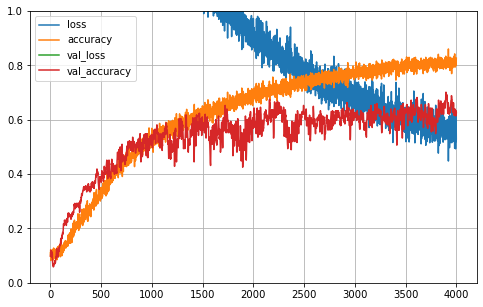

In [ ]:
#####relu 대신 leaky relu 써보자########
#####Adam보단 RMSprop이 좋은 듯도?######
#####후에 early stopping도 추가 ########

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#model_10
from tensorflow import keras
#model_9-3 9-2에서 optimizer만 RMSprop로 바꿔봄
from tensorflow import keras
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add,
    Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(10, activation='softmax'))

    #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), Adagrad(lr=0.01, epsilon=None, decay=0.0), adadelta, adam
    model.compile(optimizer=RMSprop(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = model_fn()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1201 (Conv2D)         (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_1157 (Ba (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_630 (LeakyReLU)  (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1202 (Conv2D)         (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_1158 (Ba (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_631 (LeakyReLU)  (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1203 (Conv2D)         (None, 28, 28, 16)       

In [ ]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.975 ** x)

In [ ]:
epochs = 150
batch_size = 32

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[annealer]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

Epoch 1/150
54/54 [==============================] - 1s 25ms/step - loss: 2.4998 - accuracy: 0.1276 - val_loss: 2.2552 - val_accuracy: 0.1526
Epoch 2/150
54/54 [==============================] - 1s 16ms/step - loss: 2.2659 - accuracy: 0.1593 - val_loss: 2.1527 - val_accuracy: 0.2273
Epoch 3/150
54/54 [==============================] - 1s 17ms/step - loss: 2.1901 - accuracy: 0.1868 - val_loss: 2.3029 - val_accuracy: 0.1201
Epoch 4/150
54/54 [==============================] - 1s 17ms/step - loss: 2.1149 - accuracy: 0.2330 - val_loss: 2.4806 - val_accuracy: 0.1039
Epoch 5/150
54/54 [==============================] - 1s 17ms/step - loss: 2.0548 - accuracy: 0.2617 - val_loss: 3.0083 - val_accuracy: 0.1039
Epoch 6/150
54/54 [==============================] - 1s 17ms/step - loss: 1.9871 - accuracy: 0.2875 - val_loss: 2.8759 - val_accuracy: 0.1039
Epoch 7/150
54/54 [==============================] - 1s 16ms/step - loss: 1.8967 - accuracy: 0.3226 - val_loss: 2.7598 - val_accuracy: 0.1169
Epoch 

54/54 [==============================] - 1s 16ms/step - loss: 0.5488 - accuracy: 0.8021 - val_loss: 0.5931 - val_accuracy: 0.7890
Epoch 116/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5346 - accuracy: 0.8197 - val_loss: 0.6279 - val_accuracy: 0.7955
Epoch 117/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5494 - accuracy: 0.8138 - val_loss: 0.6057 - val_accuracy: 0.7922
Epoch 118/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5358 - accuracy: 0.8208 - val_loss: 0.6448 - val_accuracy: 0.7857
Epoch 119/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5234 - accuracy: 0.8185 - val_loss: 0.6424 - val_accuracy: 0.7792
Epoch 120/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5441 - accuracy: 0.8197 - val_loss: 0.6297 - val_accuracy: 0.7825
Epoch 121/150
54/54 [==============================] - 1s 16ms/step - loss: 0.5419 - accuracy: 0.8050 - val_loss: 0.6185 - val_accuracy: 0.7890
Epoch 

In [ ]:
#9까지는 콘볼루션 층 9개에 맥스풀링과 FC 첨가해서 필터 수나 러닝 레이트만 조절해봄
#이번 model_10은 LeNet 참고하여 비슷한 구조로 얕게 층 쌓음 - 훈련 모델에 대한 오버피팅 심함

#conv 층과 maxpooling 층에 strides=2 추가해서 해봄

#randomsearch로 learning rate 등 하이퍼 파라미터 조절해보기
#차라리 learning rate 줄이고 많이 시도? 진동하는 경향이 좀 보임 epoch 75부터 계~~~~속 0.7대 유지 - epoch 161 아직도 탈출 못함
#0.003으로 했을 때 진동하는 듯 해서 0.001로 다시 돌아옴 - 근데 학습률이 낮아도 마찬가지로 local 최적에 빠지지 않을까? - global 최적 찾을 방법은??
#이것도 진동에 빠진다면 0.002로 시도해보기

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#model_11 - 모델 10에서 Leaky ReLU나 PReLU나 Maxout 시도해보기
#아무튼 적당한 활성화 함수 찾은 후 RandomSearch로 하이퍼파라미터 최적화
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch

from keras import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout,
    Flatten, Dense, Input, Concatenate, LeakyReLU, PReLU, 
    Add, Activation, BatchNormalization, MaxPooling2D
)

#데이터 증강
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.1, #10퍼센트 확대
                             width_shift_range=0.1,
                             height_shift_range=0.1)

def model_fn():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal', input_shape = train_X.shape[1:]))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(16, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(32, (3,3), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(64, (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = model_fn()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1174 (Conv2D)         (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_600 (LeakyReLU)  (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1175 (Conv2D)         (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_601 (LeakyReLU)  (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1176 (Conv2D)         (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_602 (LeakyReLU)  (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 28, 28, 16)       

In [ ]:
#각 epoch마다 learning rate 낮춰줌
from tensorflow.keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.975 ** x)

In [ ]:
epochs = 230
batch_size = 32

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=train_X.shape[0]//batch_size,
    validation_data=(valid_X,valid_y),
    verbose=1,
    callbacks=[annealer]
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(history.history['accuracy']):.5f}, " +
    f"Validation accuracy={max(history.history['val_accuracy']):.5f}"
)

In [ ]:
test_loss, test_acc = model.evaluate(valid_X, valid_y, verbose=2)
print('테스트 손실함수:', test_loss, '\n테스트 정확도:', test_acc)

시도해볼 것: maxout은 dropout과 함께 쓰면 효과가 좋은 활성화함수라고 함
    - maxout 적용 예제 / 코드 찾아서 직접 사용해보기
    - maxout의 단점은 파라미터의 수가 두배가 된다는 점
             maxpooling만 쓰지 말고 각 방법의 장단점 파악 후 새롭게 적용해보기

Summary
Stanford의 CS231n 강의에서는 다음과 같은 순서로 Activation function을 시도해볼 것을 권한다.

(1) ReLU를 사용하자.

(2) 성능이 만족스럽지 않다면, LeakyReLU, Maxout, ELU를 사용하라.

(3) 그래도 만족스럽지 않다면, tanh를 사용하라. 하지만 많은 기대는 하지말자.

(4) 그러나 Sigmoid는 사용하지 말라.

실무적으로는 ReLU를 가장 많이 사용하며, LeakyReLU/Maxout/ELU도 좋은 선택지가 될 수 있다.


learning rate 점점 감소 시켰을 때: 0.7941

그냥 없이 했을 때: 0.8284

model_5: train - 0.87, valid - 0.82

model_6: Train accuracy=0.89975, Validation accuracy=0.82195

강아지 품종 분류 cnn, 데이터 부풀리기 비교 예제

# https://lsjsj92.tistory.com/387

cnn
# https://m.blog.naver.com/laonple/221212462034

https://m.blog.naver.com/laonple/220808903260

# https://buomsoo-kim.github.io/keras/2018/05/05/Easy-deep-learning-with-Keras-11.md/

https://machine-geon.tistory.com/46

https://excelsior-cjh.tistory.com/152

cnn 정확도 높이기

https://manofconcrete.blogspot.com/2019/12/mnist-hands-on-3.html

randpm search vs grid search

https://shwksl101.github.io/ml/dl/2019/01/30/Hyper_parameter_optimization.html

케라스 튜너
# https://github.com/keras-team/keras-tuner
https://tykimos.github.io/2019/05/10/KerasTuner/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
'''def model_fn():
    LR = Choice('learning_rate', [0.001, 0.0005, 0.0001], group='optimizer')
    DROPOUT_RATE = Linear('dropout_rate', 0.0, 0.5, 5, group='dense')
    NUM_DIMS = Range('num_dims', 8, 32, 8, group='dense')
    NUM_LAYERS = Range('num_layers', 1, 3, group='dense')
    L2_NUM_FILTERS = Range('l2_num_filters', 8, 64, 8, group='cnn')
    L1_NUM_FILTERS = Range('l1_num_filters', 8, 64, 8, group='cnn')

    model = Sequential()
    model.add(Conv2D(L1_NUM_FILTERS, kernel_size=(3, 3), activation='relu'), input_shape = train_X.shape[1:])
    model.add(Conv2D(L2_NUM_FILTERS, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    for _ in range(NUM_LAYERS):
        model.add(Dense(NUM_DIMS, activation='relu'))
        model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(LR), metrics=['accuracy'])

    return model'''

In [ ]:
'''def create_cnn_model(train_x):
    inputs = tf.keras.layers.Input(train_x.shape[1:])
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2,2))(conv)
    
    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2,2))(conv)
    
    flatten = tf.keras.layers.Flatten()(pool)
    
    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model'''

In [ ]:
'''model = create_cnn_model(train_X)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=20)'''

In [ ]:
'''test_loss, test_acc = model.evaluate(valid_X, valid_y, verbose=2)
print('테스트 손실함수:', test_loss, '\n테스트 정확도:', test_acc)'''

https://excelsior-cjh.tistory.com/152

In [ ]:
'''import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2

np.random.seed(0)

train = pd.read_csv('./data/cvision/train.csv')
train_x = train.iloc[:,3:].values.reshape(-1,28,28)
data = train_x[0]
data.shape'''

In [ ]:
'''#상하좌우 이동
samples = np.expand_dims(data, 0)

#Generator 생성
#range를 설정해 얼마나 움직일지 정해줌
gen = ImageDataGenerator(width_shift_range=[-10,10])

#figure 생성
fig = plt.figure(figsize=(28,28))

#it
it = gen.flow(samples, batch_size=1)

#9개 이미지 생성
for i in range(9):
    plt.subplot(3,3,i+1)
    
    batch = it.next()
    img = batch[0].astype('uint8')
    
    #plot raw pixel data
    plt.imshow(img)
    
#show the figure
plt.title('moving')
plt.show()'''

In [ ]:
#ResNet - Residual Block

'''
from keras import layers

def residual_block(x, filters_in, filters_out, k_size):
    shortcut = x
    x = layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)    
    
    x = layers.Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    shortcut_channel = x.shape.as_list()[-1]
    
    if shortcut_channel != filters_out:
        shortcut = layers.Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same")(shortcut)
        
    x = layers.Add()([x, shortcut])
    return layers.LeakyReLU()(x)
'''